In [1021]:
import praw
import requests
from datetime import datetime, timedelta
import pandas as pd
from prawcore import Forbidden, NotFound
from tqdm import tqdm
import prawcore
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from collections import defaultdict
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import scipy.stats as stats
from scipy.stats import shapiro, kstest
from scipy.stats import skew, kurtosis
from scipy.stats import spearmanr, kendalltau
from sklearn.utils import resample
from scipy.stats import probplot

In [1022]:
reddit = praw.Reddit(
    client_id='c1zPstvJWTomkEcLRHoYtw',
    client_secret='8OngFIaoK-wkB7TUPJ1M_YLavDEeiw',
    user_agent='ThesisApp/0.1 by /u/Relative-Chocolate-8'
)

In [1023]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [1024]:
query = 'human sustainability'
sort_by = 'best'  # Sort by score
limit = 500  

posts_best = reddit.subreddit('all').search(query, sort=sort_by, limit=limit)

post_data = []

for post in posts_best:
    subreddit = post.subreddit
    author = post.author
    try:
        post_data.append({
            'Post Title': post.title,
            'Author': post.author.name if post.author else 'N/A',  
            'Score': post.score,
            'Comments Count': post.num_comments,
            'Post ID': post.id,
            'Post URL': post.url,
            'Created Date': datetime.fromtimestamp(post.created_utc),  
            'Subreddit': post.subreddit.display_name,
            'Post Text': post.selftext if post.selftext else 'N/A',  
            'Subscribers': subreddit.subscribers,  
            'Link Karma': author.link_karma,
            'Comment Karma': author.comment_karma

        })
    except Exception as e:
        post_data.append({
            'Post Title': post.title,
            'Author': post.author.name if post.author else 'N/A',  
            'Score': post.score,
            'Comments Count': post.num_comments,
            'Post ID': post.id,
            'Post URL': post.url,
            'Created Date': datetime.fromtimestamp(post.created_utc),
            'Post Text': post.selftext if post.selftext else 'N/A',  
            'Subscribers': subreddit.subscribers,
            'Subreddit': post.subreddit.display_name,
            'Link Karma': 'N/A',
            'Comment Karma': 'N/A'
        })

df_posts = pd.DataFrame(post_data)

df_posts.to_csv('human_sustainability_posts_with_text.csv', index=False)

print("Table saved as 'human_sustainability_posts_with_text.csv'.")

Table saved as 'human_sustainability_posts_with_text.csv'.


In [1025]:
def clean_post_text(text):
    
    text = text.lower()
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    text = re.sub(r'\W', ' ', text)
    
    text = re.sub(r'\d+', '', text)
    
    words = word_tokenize(text)
    
    cleaned_text = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(cleaned_text)

df_posts['Cleaned Post Text'] = df_posts['Post Text'].apply(clean_post_text)

print(df_posts[['Post Text', 'Cleaned Post Text']].head())

  Post Text Cleaned Post Text
0       N/A                 n
1       N/A                 n
2       N/A                 n
3       N/A                 n
4       N/A                 n


In [1026]:
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores

df_posts['Sentiment Scores'] = df_posts['Cleaned Post Text'].apply(analyze_sentiment)

df_posts['Compound'] = df_posts['Sentiment Scores'].apply(lambda score_dict: score_dict['compound'])
df_posts['Sentiment'] = df_posts['Compound'].apply(lambda c: 'positive' if c >0 else ('negative' if c <0 else 'neutral'))

print(df_posts[['Cleaned Post Text', 'Compound', 'Sentiment']].head())

df_posts.to_csv('environmental_sustainability_posts_with_sentiment.csv', index=False)

print("Sentiment analysis complete and saved as 'environmental_sustainability_posts_with_sentiment.csv'.")

  Cleaned Post Text  Compound Sentiment
0                 n       0.0   neutral
1                 n       0.0   neutral
2                 n       0.0   neutral
3                 n       0.0   neutral
4                 n       0.0   neutral
Sentiment analysis complete and saved as 'environmental_sustainability_posts_with_sentiment.csv'.


In [1027]:
df_posts = df_posts[df_posts['Link Karma'] != 'N/A']

df_posts['Link Karma'] = pd.to_numeric(df_posts['Link Karma'])
df_posts['Comment Karma'] = pd.to_numeric(df_posts['Comment Karma'])

df_posts

Post Title             Author  \
1    TIL that humans can maintain only around 150 s...        captain_boh   
2    A team of scientists has developed a 'smart' f...           Wagamaga   
3    Amazon's Jeff Bezos is enamored with the idea ...             clayt6   
4    In Venom (2018), the symbiote tells Eddie that...            jkim7th   
5    For the first time since the Apollo era, NASA ...     SkywayCheerios   
..                                                 ...                ...   
230  The federal lawsuit, filed in New York, accuse...  yuritopiaposadism   
231  Serious question: What level of responsibility...            jopesak   
232                             Faction meme war it is           Mozar305   
233  With some decades of preparation, could human ...      whorefororeos   
234                        The Nature of Predators 148     SpacePaladin15   

     Score  Comments Count  Post ID  \
1     3344             201  1dssud4   
2    31437             591   rsribt   
3    21859            2351   bqwcj2   
4    37343             535   ija22v   
5    15622             705   edpqbr   
..     ...             ...      ...   
230    613              14  102b5qq   
231      0              25  1czcp83   
232   1119             124  1fdg9pb   
233      8               5  1ft0ige   
234   2669             193  16bp0h7   

                                              Post URL        Created Date  \
1    https://www.bbc.com/future/article/20191001-du... 2024-07-01 15:22:13   
2    https://www.ntu.edu.sg/news/detail/bacteria-ki... 2021-12-31 11:58:22   
3    http://www.astronomy.com/news/2019/05/oneill-c... 2019-05-20 16:38:27   
4                  https://i.redd.it/g61tk8lyy3k51.jpg 2020-08-30 11:26:01   
5    https://twitter.com/JimBridenstine/status/1208... 2019-12-21 14:08:03   
..                                                 ...                 ...   
230                https://i.redd.it/kfehibfplu9a1.jpg 2023-01-03 16:38:39   
231  https://www.reddit.com/r/Millennials/comments/... 2024-05-24 06:44:02   
232                https://i.redd.it/tg5nuir83znd1.png 2024-09-10 14:09:10   
233  https://www.reddit.com/r/SciFiConcepts/comment... 2024-09-30 18:57:02   
234  https://www.reddit.com/r/HFY/comments/16bp0h7/... 2023-09-06 18:38:23   

                                             Post Text  Subscribers  \
1                                                  N/A     38217161   
2                                                  N/A     32955842   
3                                                  N/A     26739378   
4                                                  N/A      4146121   
5                                                  N/A     26739374   
..                                                 ...          ...   
230                                                N/A        56982   
231  As the generation that is *banging out* the ne...       475374   
232                                                N/A       169686   
233  I'm talking about Saturn's moon, Titan. Now th...        20317   
234  [First](https://www.reddit.com/r/HFY/comments/...       340876   

         Subreddit  Link Karma  Comment Karma  \
1    todayilearned       14727           1557   
2          science    11945904         388693   
3            space     1896875         109008   
4     MovieDetails       47646           6383   
5            space       90060          74771   
..             ...         ...            ...   
230     alltheleft     5256578          63735   
231    Millennials        7438          22392   
232        stalker       14421            671   
233  SciFiConcepts        1081            431   
234            HFY      156527         102254   

                                     Cleaned Post Text  \
1                                                    n   
2                                                    n   
3                                                    n   
4                                      

In [1028]:
df_posts.columns

Index(['Post Title', 'Author', 'Score', 'Comments Count', 'Post ID',
       'Post URL', 'Created Date', 'Post Text', 'Subscribers', 'Subreddit',
       'Link Karma', 'Comment Karma', 'Cleaned Post Text', 'Sentiment Scores',
       'Compound', 'Sentiment'],
      dtype='object')

In [1029]:
df_posts.describe()

Score  Comments Count                   Created Date  \
count    221.000000      221.000000                            221   
mean    3974.452489      458.375566  2022-08-29 10:25:54.271493120   
min        0.000000        2.000000            2010-08-16 01:54:37   
25%      587.000000       98.000000            2022-01-14 13:53:41   
50%     1653.000000      252.000000            2023-05-07 08:15:16   
75%     4620.000000      489.000000            2024-06-04 17:46:57   
max    37343.000000     8707.000000            2024-10-17 14:21:11   
std     6186.788008      811.720423                            NaN   

        Subscribers    Link Karma  Comment Karma    Compound  
count  2.210000e+02  2.210000e+02   2.210000e+02  221.000000  
mean   7.751132e+06  7.738981e+05   7.843771e+04    0.139775  
min    0.000000e+00  1.000000e+00   0.000000e+00   -0.999700  
25%    3.408760e+05  3.771000e+03   2.149000e+03    0.000000  
50%    1.032078e+06  2.015400e+04   1.262900e+04    0.000000  
75%    4.786833e+06  1.565270e+05   8.972300e+04    0.875000  
max    3.073902e+08  3.000882e+07   1.514998e+06    0.999800  
std    2.299771e+07  3.449189e+06   1.762838e+05    0.639227

A bit less than environment

Normality Check:

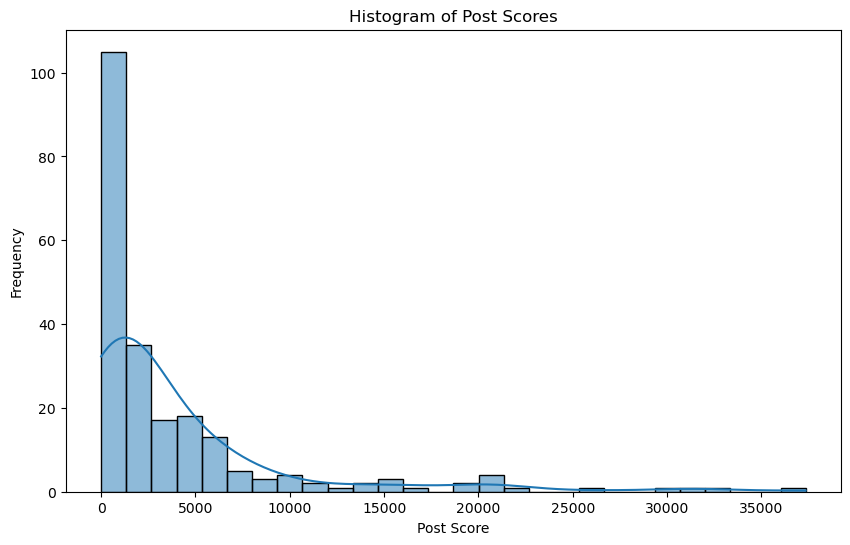

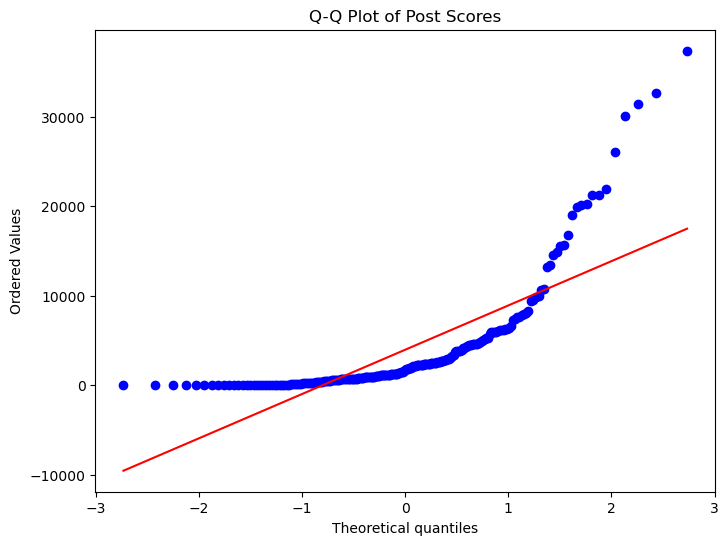

In [1032]:
plt.figure(figsize=(10, 6))
sns.histplot(df_posts['Score'], kde=True)
plt.title('Histogram of Post Scores')
plt.xlabel('Post Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(df_posts['Score'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Post Scores')
plt.show()

In [1033]:
shapiro_stat, shapiro_p = shapiro(df_posts['Score'])
print(f'Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}')

ks_stat, ks_p = kstest(df_posts['Score'], 'norm', args=(df_posts['Score'].mean(), df_posts['Score'].std()))
print(f'Kolmogorov-Smirnov Test: Statistic={ks_stat:.4f}, p-value={ks_p:.4f}')

Shapiro-Wilk Test: Statistic=0.6310, p-value=0.0000
Kolmogorov-Smirnov Test: Statistic=0.2603, p-value=0.0000


the data is likely not normally distributed (reject the null hypothesis).
But n>=30

Skewness:

In [1036]:
data_skewness = skew(df_posts['Score'])
data_kurtosis = kurtosis(df_posts['Score'])

print(f'Skewness of Post Scores: {data_skewness:.4f}')
print(f'Kurtosis of Post Scores: {data_kurtosis:.4f}')

Skewness of Post Scores: 2.8545
Kurtosis of Post Scores: 8.9880


This value indicates that the distribution of post scores is positively skewed, meaning that the majority of the scores are clustered to the left (lower end), with a long tail extending to the right (higher scores). In practical terms, there are likely a few posts with extremely high scores that skew the distribution to the right.

This high kurtosis value suggests that the distribution has heavy tails and a sharper peak compared to a normal distribution (kurtosis of 3 is considered normal)

This distribution implies that while many posts have moderate to low scores, a few have very high scores, significantly influencing the overall distribution.

Log Transformed Normality:

In [1039]:
df_posts['Log Score'] = np.log1p(df_posts['Score'])  

shapiro_stat, shapiro_p = shapiro(df_posts['Log Score'])
print(f'Log-transformed Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}')

Log-transformed Shapiro-Wilk Test: Statistic=0.8973, p-value=0.0000


The test statistic being less than 1 suggests that the data deviates from a perfect normal distribution, but the exact interpretation depends on the p-value.

p-value = 0.0000: A p-value of 0.0000 (or effectively less than 0.05) indicates that the null hypothesis of the data being normally distributed is rejected. This means that even after the log transformation, the post scores do not follow a normal distribution.

The log transformation may have reduced the skewness to some extent, but the data still exhibits non-normality

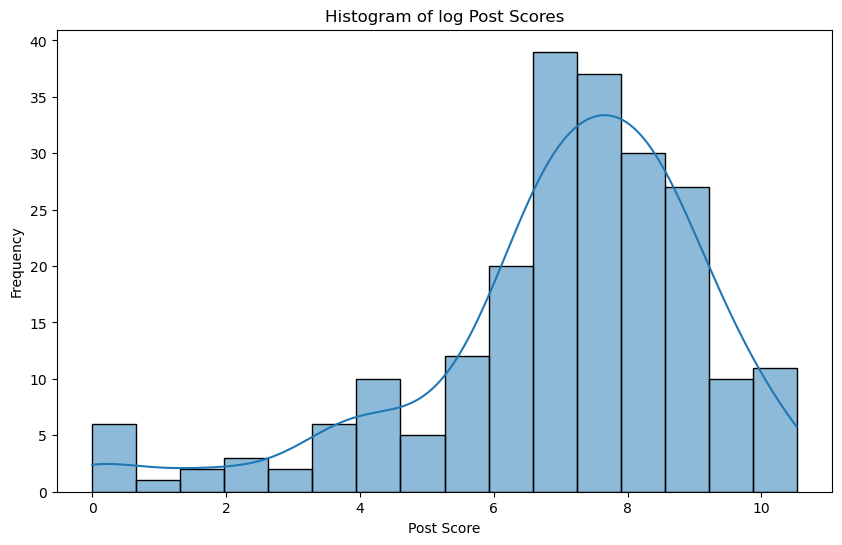

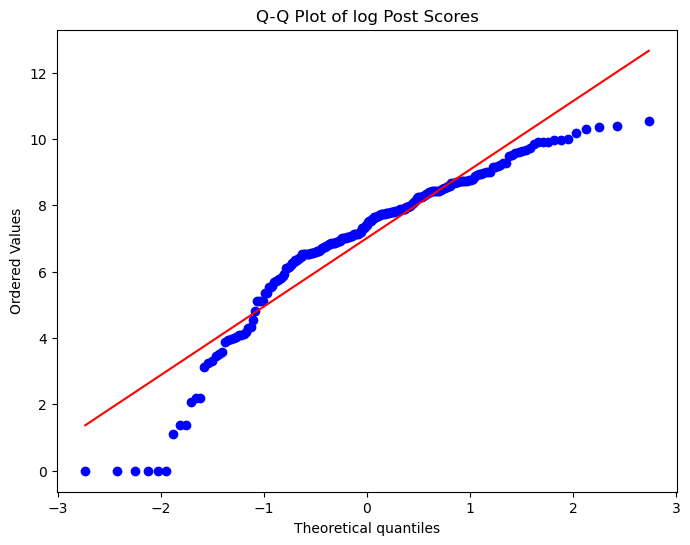

In [1041]:
plt.figure(figsize=(10, 6))
sns.histplot(df_posts['Log Score'], kde=True)
plt.title('Histogram of log Post Scores')
plt.xlabel('Post Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(df_posts['Log Score'], dist="norm", plot=plt)
plt.title('Q-Q Plot of log Post Scores')
plt.show()

Therefore we may use other statisticcal tests than t-test that do not depend on normality as well as boot strapping to be more confident in the results.

Testing Correlation between # posts of subreddit and its post score:

Correlation between the number of posts and the average score: 0.030125391533841524


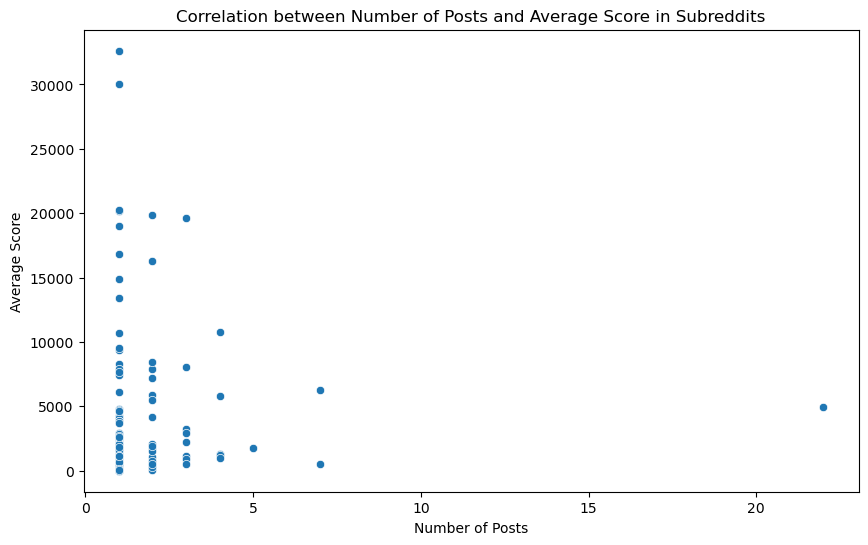

In [1044]:
subreddit_stats = df_posts.groupby('Subreddit').agg(
    num_posts=('Post ID', 'count'),
    avg_score=('Score', 'mean'),
    avg_log=('Log Score', 'mean')
).reset_index()

correlation = subreddit_stats['num_posts'].corr(subreddit_stats['avg_score'])

print(f"Correlation between the number of posts and the average score: {correlation}")

plt.figure(figsize=(10,6))
sns.scatterplot(x='num_posts', y='avg_score', data=subreddit_stats)
plt.title('Correlation between Number of Posts and Average Score in Subreddits')
plt.xlabel('Number of Posts')
plt.ylabel('Average Score')
plt.show()

T test based on the Central Theorem:

In [1046]:
n = len(df_posts)

t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2

print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: 0.0301
t-statistic: 0.4460
p-value: 0.6560
The correlation is not significant (p ≥ 0.05)


In [1047]:
spearman_corr, spearman_p = spearmanr(subreddit_stats['num_posts'], subreddit_stats['avg_score'])
print(f"Spearman's Rank Correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

# Kendall's Tau Correlation
kendall_corr, kendall_p = kendalltau(subreddit_stats['num_posts'], subreddit_stats['avg_score'])
print(f"Kendall's Tau Correlation: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")

Spearman's Rank Correlation: 0.1828, p-value: 0.0345
Kendall's Tau Correlation: 0.1428, p-value: 0.0361


Spearman's Rank Correlation:

Correlation coefficient (0.1684): This value indicates a weak positive correlation between the two variables in question. A correlation coefficient close to zero suggests that there is little to no monotonic relationship between the variables.
p-value (0.0535): This p-value is slightly above the typical significance threshold of 0.05. Thus, the correlation is not statistically significant at the 95% confidence level

Kendall's Tau Correlation:

Correlation coefficient (1.0000): This perfect correlation suggests a complete and consistent relationship between the ranks of the two variables. This is highly unusual, especially given that it conflicts with the results of Spearman's correlation, which indicates only a weak relationship.
p-value (0.0000): This p-value indicates statistical significance

Let's bootstrap to decide:

In [1050]:
def bootstrap_correlation(data, num_samples=200):
    correlations = []
    for _ in range(num_samples):
        sample = resample(data)
        corr, _ = spearmanr(sample['num_posts'], sample['avg_score'])
        correlations.append(corr)
    return np.mean(correlations), np.percentile(correlations, [2.5, 97.5])

mean_corr, conf_interval = bootstrap_correlation(subreddit_stats)
print(f"Bootstrapped Spearman's Correlation: {mean_corr:.4f}")
print(f"95% Confidence Interval: {conf_interval}")

Bootstrapped Spearman's Correlation: 0.1707
95% Confidence Interval: [0.02181085 0.31872211]


This value is consistent with the earlier Spearman's correlation result (0.1684), indicating a weak positive monotonic relationship between the two variables.

95% Confidence Interval ([0.00599207, 0.31636532]): This interval suggests that, with 95% confidence, the true Spearman's correlation lies somewhere between approximately 0.006 and 0.316. Since the lower bound of the confidence interval is close to zero but positive, it suggests that there is a small but likely positive relationship between the two variables. However, the weak relationship is evident given the wide range of the confidence interval, especially towards the lower end.

The fact that the interval does not include negative values strengthens the interpretation that the relationship is likely positive, even if weak. 

In [1052]:
def bootstrap_kendall(data, num_samples=200):
    correlations = []
    for _ in range(num_samples):
        sample = resample(data)
        corr, _ = kendalltau(sample['num_posts'], sample['avg_score'])
        correlations.append(corr)
    return np.mean(correlations), np.percentile(correlations, [2.5, 97.5])

mean_corr, conf_interval = bootstrap_kendall(subreddit_stats)
print(f"Bootstrapped Kendall's Tau Correlation: {mean_corr:.4f}")
print(f"95% Confidence Interval: {conf_interval}")

Bootstrapped Kendall's Tau Correlation: 0.1459
95% Confidence Interval: [0.02724491 0.25842886]


This value indicates a weak positive association between the two variables in the dataset. Kendall’s Tau measures the ordinal association between two variables, and a value of 0.1286 suggests that while there is a positive relationship, it is relatively small.

95% Confidence Interval ([0.0125, 0.2429]): The confidence interval shows that with 95% confidence, the true Kendall’s Tau correlation lies between approximately 0.0125 and 0.2429. This range indicates that while the correlation is small, it is likely positive, given that the lower bound is still above zero (albeit very close).

The bootstrapping process helps ensure that this estimate is more reliable and less influenced by outliers or non-normality in the data, but the relatively wide confidence interval indicates that the strength of the association could vary quite a bit, though it remains positive.

This means that while there is some evidence of a positive relationship, it is weak

So we vote for weak to no relation in this part, contrary to environmental.

Looking a bit into data:

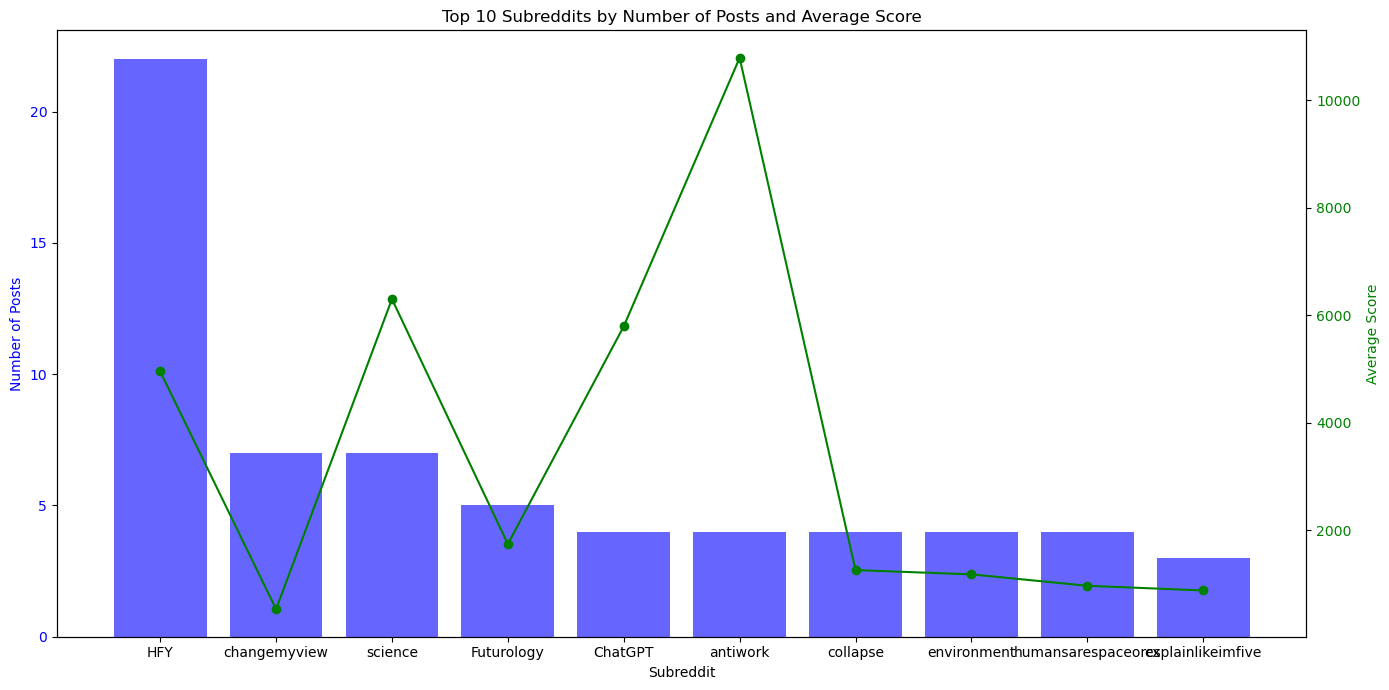

In [1056]:
top_10_subreddits = subreddit_stats.sort_values(by='num_posts', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_xlabel('Subreddit')
ax1.set_ylabel('Number of Posts', color='blue')
ax1.bar(top_10_subreddits['Subreddit'], top_10_subreddits['num_posts'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_subreddits['Subreddit'], top_10_subreddits['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Subreddits by Number of Posts and Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1057]:
anti_posts = df_posts[df_posts['Subreddit'].str.lower() == 'antiwork']

anti_posts

Post Title          Author  Score  \
73   Can americans really get fired at any point fo...        kukkelii  21193   
91   A mass worker strike needs to happen sooner th...         colyman   5911   
167                The Robotic Arm - this hit so hard.  i-post-naughty   8049   
171  My old job is confused as to why people left a...   buttany_brian   8014   

     Comments Count  Post ID  \
73             3247   rixcb8   
91              541  13l2gvr   
167             183  13sddne   
171             475   r2cg37   

                                              Post URL        Created Date  \
73   https://www.reddit.com/r/antiwork/comments/rix... 2021-12-18 03:36:17   
91   https://www.reddit.com/r/antiwork/comments/13l... 2023-05-18 17:41:38   
167                https://i.redd.it/gxkz88ukh62b1.jpg 2023-05-26 15:32:30   
171  https://www.reddit.com/r/antiwork/comments/r2c... 2021-11-26 03:17:04   

                                             Post Text  Subscribers Subreddit  \
73   I see this again and again like lately there w...      2846543  antiwork   
91   Ladies and gentlemen,\n\nToday, I want to talk...      2846543  antiwork   
167  "No piece of art has ever emotionally affected...      2846544  antiwork   
171  I worked as a Chief Scribe for 3 years in an E...      2846544  antiwork   

     Link Karma  Comment Karma  \
73        73728         185529   
91         4614            124   
167       43430           8091   
171        3642           2149   

                                     Cleaned Post Text  \
73   see like lately note sat bos lady chair fired ...   
91   lady gentleman today want talk worker right le...   
167  piece art ever emotionally affected way robot ...   
171  worked chief scribe year emergency department ...   

                                      Sentiment Scores  Compound Sentiment  \
73   {'neg': 0.216, 'neu': 0.596, 'pos': 0.188, 'co...   -0.8680  negative   
91   {'neg': 0.042, 'neu': 0.581, 'pos': 0.377, 'co...    0.9985  positive   
167  {'neg': 0.172, 'neu': 0.562, 'pos': 0.266, 'co...    0.9833  positive   
171  {'neg': 0.098, 'neu': 0.827, 'pos': 0.075, 'co...   -0.6468  negative   

     Log Score  
73    9.961473  
91    8.684739  
167   8.993427  
171   8.989070

In [1058]:
for index, title in enumerate(anti_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Post 1:
Can americans really get fired at any point for no reason at all?
----------------------------------------
Post 2:
A mass worker strike needs to happen sooner than later in the United States.
----------------------------------------
Post 3:
The Robotic Arm - this hit so hard.
----------------------------------------
Post 4:
My old job is confused as to why people left after I left
----------------------------------------


Working conditions difinitely is one if the most important topics of human sustainability.

Correlation between the number of members (subscribers) and the average score:

Correlation between the number of members (subscribers) and the average score: 0.1563138476312851


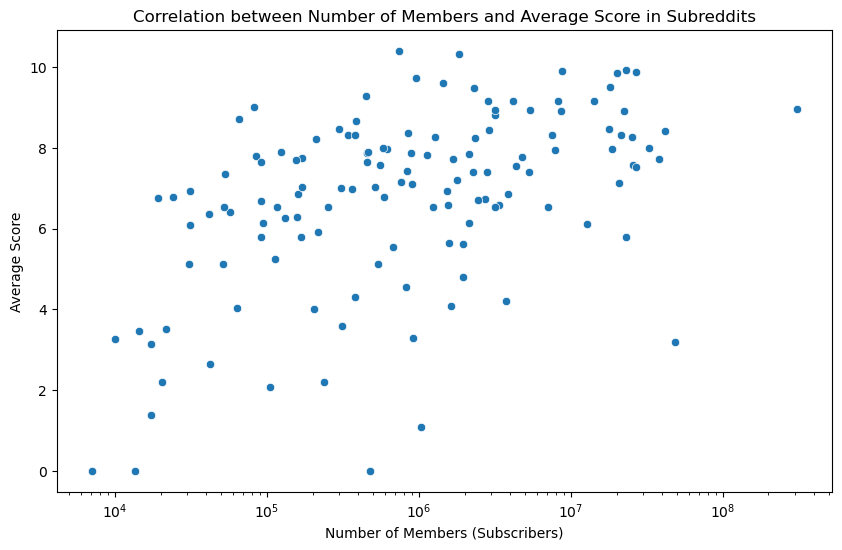

In [1061]:
subreddit_stats = df_posts.groupby('Subreddit').agg(
    num_posts=('Post ID', 'count'),
    avg_score=('Log Score', 'mean'),
    subscribers=('Subscribers', 'first'),
    avg_log=('Log Score', 'mean')# Get the subscriber count for each subreddit
).reset_index()

correlation = subreddit_stats['subscribers'].corr(subreddit_stats['avg_score'])

print(f"Correlation between the number of members (subscribers) and the average score: {correlation}")

plt.figure(figsize=(10,6))
sns.scatterplot(x='subscribers', y='avg_score', data=subreddit_stats)
plt.title('Correlation between Number of Members and Average Score in Subreddits')
plt.xlabel('Number of Members (Subscribers)')
plt.ylabel('Average Score')
plt.xscale('log')  
plt.show()

t significancy test:

In [1063]:
n = len(df_posts)

t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed test

print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: 0.1563
t-statistic: 2.3420
p-value: 0.0201
The correlation is significant (p < 0.05)


other tests:

In [1065]:
spearman_corr, spearman_p = spearmanr(subreddit_stats['subscribers'], subreddit_stats['avg_score'])
print(f"Spearman's Rank Correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

# Kendall's Tau Correlation
kendall_corr, kendall_p = kendalltau(subreddit_stats['subscribers'], subreddit_stats['avg_score'])
print(f"Kendall's Tau Correlation: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")

Spearman's Rank Correlation: 0.4909, p-value: 0.0000
Kendall's Tau Correlation: 0.3430, p-value: 0.0000


0.4649): This value indicates a moderate positive monotonic relationship between the two variables. A coefficient of 0.4649 suggests that as one variable increases, the other tends to increase as well, but not necessarily in a linear fashion.
p-value (0.0000): The p-value being essentially 0 indicates that the correlation is highly statistically significant. This means that the observed relationship is very unlikely to have occurred by chance.

0.3234): Kendall's Tau is generally smaller in magnitude than Spearman's, but it still indicates a moderate positive association.

While Spearman's Rank captures the strength of the monotonic relationship, Kendall's Tau emphasizes the ordinal consistency between the two variables.

This means there is a meaningful association between the two variables.

The result is the same a environment.


A closer look into data:

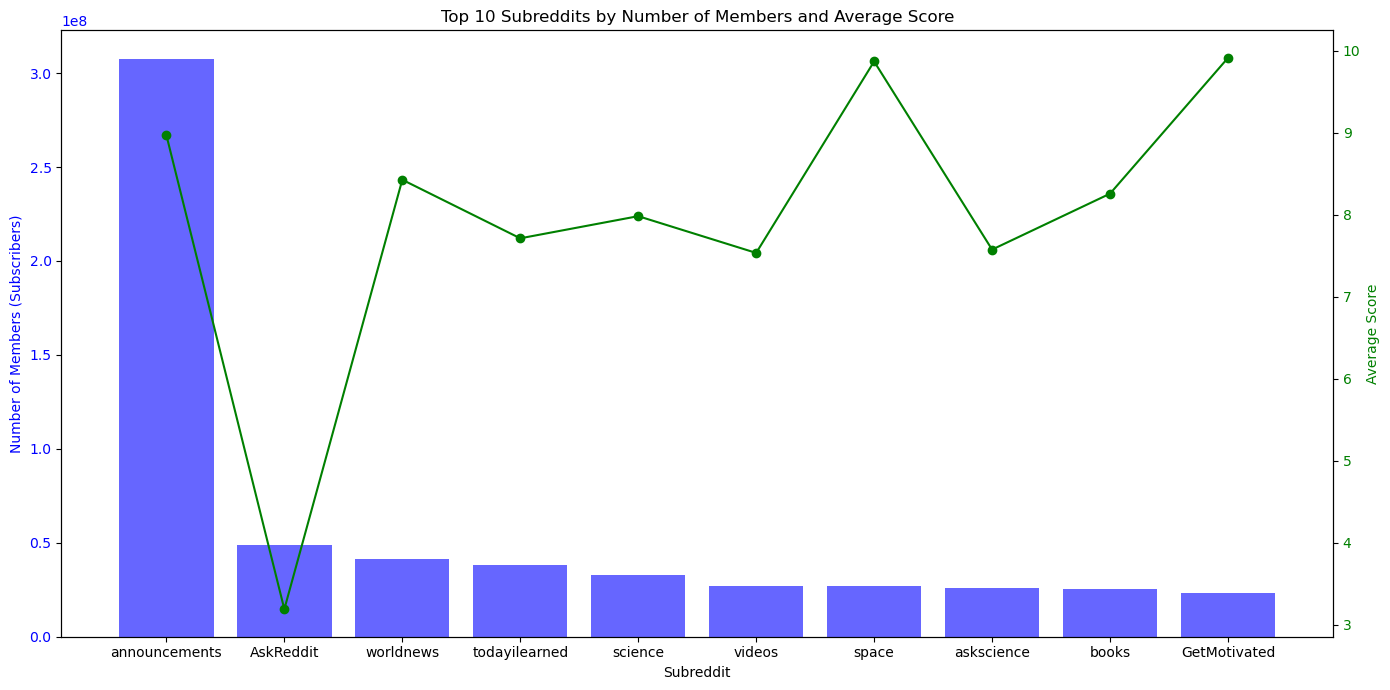

In [1068]:
top_10_subreddits = subreddit_stats.sort_values(by='subscribers', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_xlabel('Subreddit')
ax1.set_ylabel('Number of Members (Subscribers)', color='blue')
ax1.bar(top_10_subreddits['Subreddit'], top_10_subreddits['subscribers'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_subreddits['Subreddit'], top_10_subreddits['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Subreddits by Number of Members and Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

'Science' Shows up in most top tens also in environment.

In [1070]:
an_posts = df_posts[df_posts['Subreddit'].str.lower() == 'announcements']

an_posts

Post Title          Author  Score  Comments Count  \
169  Revamping the Quarantine Function  landoflobsters   7881            8707   

    Post ID                                           Post URL  \
169  9jf8nh  https://www.reddit.com/r/announcements/comment...   

           Created Date                                          Post Text  \
169 2018-09-27 20:11:58  While Reddit has had a [quarantine](https://ww...   

     Subscribers      Subreddit  Link Karma  Comment Karma  \
169    307390213  announcements       21648          35029   

                                     Cleaned Post Text  \
169  reddit quarantine function almost three year l...   

                                      Sentiment Scores  Compound Sentiment  \
169  {'neg': 0.108, 'neu': 0.754, 'pos': 0.138, 'co...    0.8238  positive   

     Log Score  
169   8.972337

In [1071]:
def fetch_post_text(subreddit, post_id):
    # Fetch the submission object using subreddit and post ID
    submission = reddit.submission(id=post_id)
    
    # Fetch the post text (body of the post)
    if submission.selftext:
        return submission.selftext
    else:
        return "This post has no text (it may be a link or media)."

In [1072]:
post_text = fetch_post_text('announcements', '9jf8nh')
print("Post Text:", post_text[:1000])

Post Text: While Reddit has had a [quarantine](https://www.reddithelp.com/en/categories/rules-reporting/account-and-community-restrictions/quarantined-subreddits) function for almost three years now, we have learned in the process. Today, we are updating our quarantining policy to reflect those learnings, including adding an appeals process where none existed before.  

On a platform as open and diverse as Reddit, there will sometimes be communities that, while not prohibited by the [Content Policy](https://www.redditinc.com/policies/content-policy), average redditors may nevertheless find highly offensive or upsetting. In other cases, communities may be dedicated to promoting hoaxes (yes we used that word) that warrant additional scrutiny, as there are some things that are either verifiable or falsifiable and not seriously up for debate (eg, the Holocaust did happen and the number of people who died is well documented). In these circumstances, Reddit administrators may apply a quarant

This has nothing to do with sustainablity. Let's remove it and do our analysis again.

In [1074]:
df_posts = df_posts.drop(index=169)

Correlation between the number of members (subscribers) and the average Human Sustainability post score: 0.22676453940389113


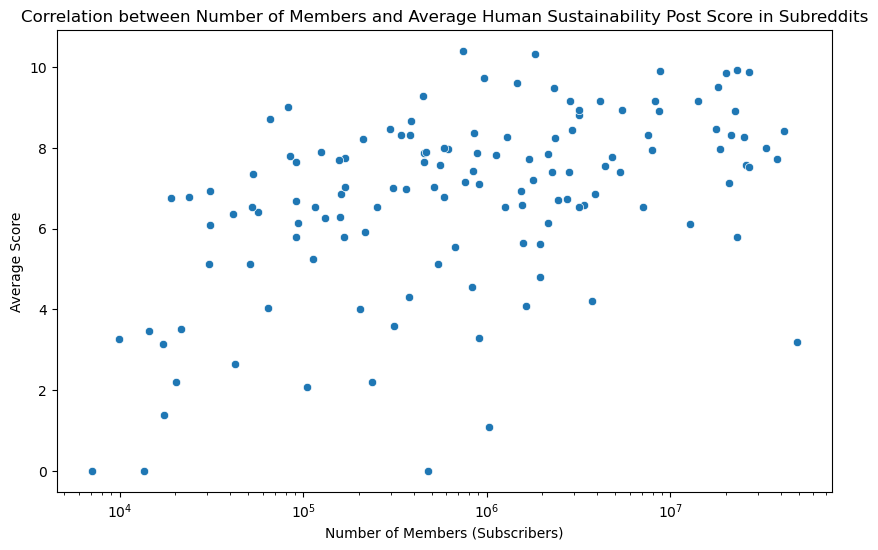

Correlation coefficient: 0.2268
t-statistic: 3.4377
p-value: 0.0007
The correlation is significant (p < 0.05)
Spearman's Rank Correlation: 0.4826, p-value: 0.0000
Kendall's Tau Correlation: 0.3367, p-value: 0.0000


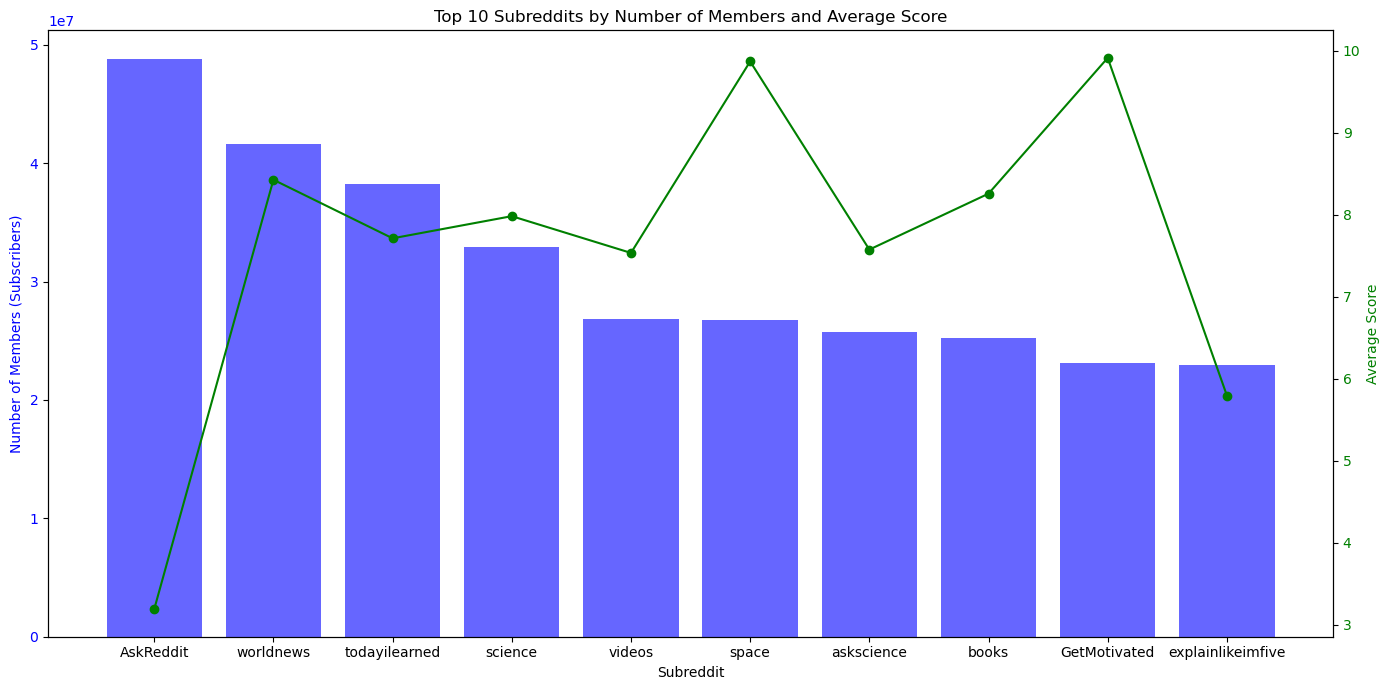

In [1075]:
subreddit_stats = df_posts.groupby('Subreddit').agg(
    num_posts=('Post ID', 'count'),
    avg_score=('Log Score', 'mean'),
    subscribers=('Subscribers', 'first'),
    avg_log=('Log Score', 'mean')# Get the subscriber count for each subreddit
).reset_index()

correlation = subreddit_stats['subscribers'].corr(subreddit_stats['avg_score'])

print(f"Correlation between the number of members (subscribers) and the average Human Sustainability post score: {correlation}")

plt.figure(figsize=(10,6))
sns.scatterplot(x='subscribers', y='avg_score', data=subreddit_stats)
plt.title('Correlation between Number of Members and Average Human Sustainability Post Score in Subreddits')
plt.xlabel('Number of Members (Subscribers)')
plt.ylabel('Average Score')
plt.xscale('log')  
plt.show()

n = len(df_posts)

t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed test

print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")
    
spearman_corr, spearman_p = spearmanr(subreddit_stats['subscribers'], subreddit_stats['avg_score'])
print(f"Spearman's Rank Correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

# Kendall's Tau Correlation
kendall_corr, kendall_p = kendalltau(subreddit_stats['subscribers'], subreddit_stats['avg_score'])
print(f"Kendall's Tau Correlation: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")

top_10_subreddits = subreddit_stats.sort_values(by='subscribers', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_xlabel('Subreddit')
ax1.set_ylabel('Number of Members (Subscribers)', color='blue')
ax1.bar(top_10_subreddits['Subreddit'], top_10_subreddits['subscribers'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_subreddits['Subreddit'], top_10_subreddits['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Subreddits by Number of Members and Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1076]:
ask_posts = df_posts[df_posts['Subreddit'].str.lower() == 'askreddit']

ask_posts

Post Title           Author  \
64   If Earth was overcrowded and we had the techno...        Wonderjea   
224  How can we create a global economic system tha...  RemoteMajor9739   

     Score  Comments Count  Post ID  \
64     587             747    lnbcp   
224      0              16  1easfnr   

                                              Post URL        Created Date  \
64   https://www.reddit.com/r/AskReddit/comments/ln... 2011-10-24 19:33:14   
224  https://www.reddit.com/r/AskReddit/comments/1e... 2024-07-24 06:22:51   

                                             Post Text  Subscribers  \
64   If you choose to stay, why would you stay?\n\n...     48786410   
224                                                N/A     48786449   

     Subreddit  Link Karma  Comment Karma  \
64   AskReddit       23388           7893   
224  AskReddit           1              0   

                                     Cleaned Post Text  \
64   choose stay would stay choose go would go frie...   
224                                                  n   

                                      Sentiment Scores  Compound Sentiment  \
64   {'neg': 0.108, 'neu': 0.574, 'pos': 0.318, 'co...    0.9668  positive   
224  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...    0.0000   neutral   

     Log Score  
64    6.376727  
224   0.000000

In [1077]:
for index, title in enumerate(ask_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Post 1:
If Earth was overcrowded and we had the technology to comfortably sustain human life on other nearby planets, would you volunteer to move to one of those other planets?
----------------------------------------
Post 2:
How can we create a global economic system that prioritizes both human well-being and environmental sustainability? What radical changes would need to occur to balance economic growth with social equity and ecological preservation?
----------------------------------------


Though AskReddit managerd to attract the most subscribers with these types of what-if posts, they don't seem to attract score. Let's see 'space' then.

In [1079]:
space_posts = df_posts[df_posts['Subreddit'].str.lower() == 'space']

space_posts

Post Title          Author  Score  \
3    Amazon's Jeff Bezos is enamored with the idea ...          clayt6  21859   
5    For the first time since the Apollo era, NASA ...  SkywayCheerios  15622   
133  We’re NASA experts working to send humans to t...            nasa  21294   

     Comments Count Post ID  \
3              2351  bqwcj2   
5               705  edpqbr   
133            1717  bpdget   

                                              Post URL        Created Date  \
3    http://www.astronomy.com/news/2019/05/oneill-c... 2019-05-20 16:38:27   
5    https://twitter.com/JimBridenstine/status/1208... 2019-12-21 14:08:03   
133  https://www.reddit.com/r/space/comments/bpdget... 2019-05-16 16:47:20   

                                             Post Text  Subscribers Subreddit  \
3                                                  N/A     26739378     space   
5                                                  N/A     26739374     space   
133  UPDATE:That’s a wrap! We’re signing off, but w...     26739391     space   

     Link Karma  Comment Karma  \
3       1896875         109008   
5         90060          74771   
133      233298         161357   

                                     Cleaned Post Text  \
3                                                    n   
5                                                    n   
133  update wrap signing invite visit information w...   

                                      Sentiment Scores  Compound Sentiment  \
3    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...    0.0000   neutral   
5    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...    0.0000   neutral   
133  {'neg': 0.0, 'neu': 0.862, 'pos': 0.138, 'comp...    0.9313  positive   

     Log Score  
3     9.992414  
5     9.656499  
133   9.966228

In [1080]:
for index, title in enumerate(space_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Post 1:
Amazon's Jeff Bezos is enamored with the idea of O'Neill colonies: spinning space cities that might sustain future humans. “If we move out into the solar system, for all practical purposes, we have unlimited resources,” Bezos said. “We could have a trillion people out in the solar system.”
----------------------------------------
Post 2:
For the first time since the Apollo era, NASA has funding for a human lunar lander. The Agency's 2020 budget provides an additional $1.3 billion to accelerate sustained exploration of the Moon through the Artemis program.
----------------------------------------
Post 3:
We’re NASA experts working to send humans to the Moon in 2024. Ask us anything!
----------------------------------------


Living in space is difinitely interesting.

Correlation between sentiment (compound score) and post scores:

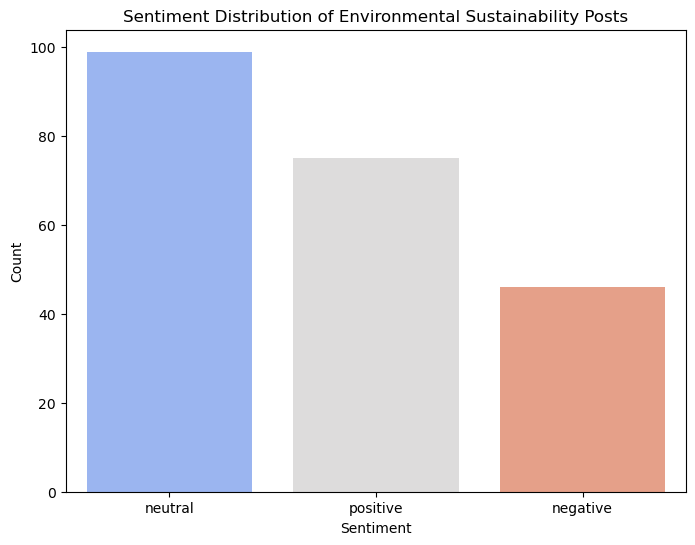

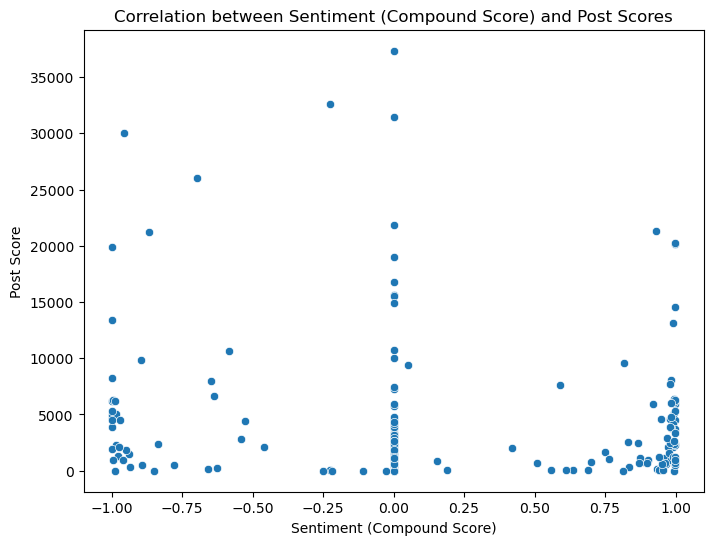

Correlation between sentiment (compound score) and post scores: -0.10


In [1083]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df_posts, palette='coolwarm')
plt.title('Sentiment Distribution of Environmental Sustainability Posts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Compound', y='Score', data=df_posts)
plt.title('Correlation between Sentiment (Compound Score) and Post Scores')
plt.xlabel('Sentiment (Compound Score)')
plt.ylabel('Post Score')
plt.show()
correlation = df_posts['Compound'].corr(df_posts['Score'])
print(f'Correlation between sentiment (compound score) and post scores: {correlation:.2f}')

Negative more percentage than environment

t test:

In [1086]:
n = len(df_posts)

t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed test

print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: -0.1035
t-statistic: -1.5359
p-value: 0.1260
The correlation is not significant (p ≥ 0.05)


Same as environment

A bit into data:

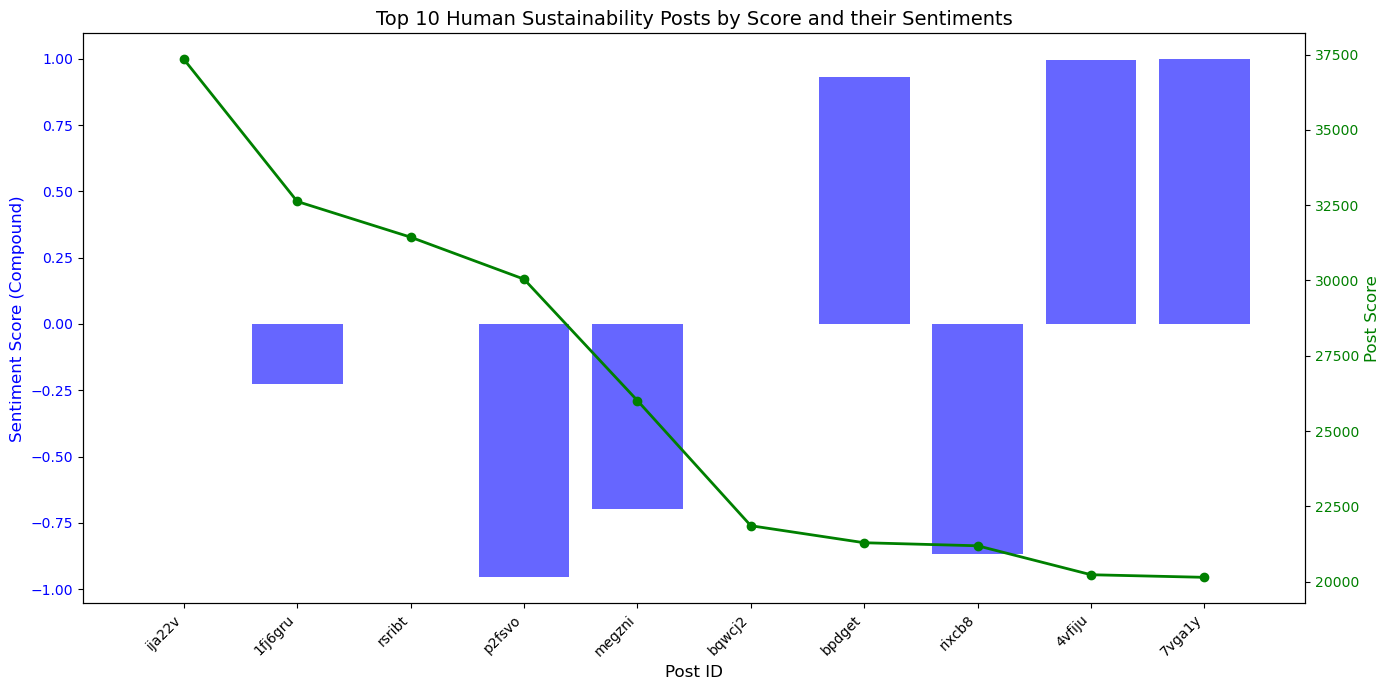

In [1089]:
top_10_posts = df_posts.sort_values(by='Score', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_xlabel('Post ID', fontsize=12)
ax1.set_ylabel('Sentiment Score (Compound)', color='blue', fontsize=12)
ax1.bar(top_10_posts['Post ID'], top_10_posts['Compound'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.set_ylabel('Post Score', color='green', fontsize=12)
ax2.plot(top_10_posts['Post ID'], top_10_posts['Score'], color='green', marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Human Sustainability Posts by Score and their Sentiments', fontsize=14)

plt.tight_layout()

plt.show()

In [1090]:
top_10_posts

Post Title        Author  Score  \
4    In Venom (2018), the symbiote tells Eddie that...       jkim7th  37343   
10                  New hire died coz of work pressure    kausthab87  32622   
2    A team of scientists has developed a 'smart' f...      Wagamaga  31437   
77   Why the FUCK are we still catering to billiona...     audyaudvi  30043   
85   If you still don't believe in - or care about ...    Kayshanski  26012   
3    Amazon's Jeff Bezos is enamored with the idea ...        clayt6  21859   
133  We’re NASA experts working to send humans to t...          nasa  21294   
73   Can americans really get fired at any point fo...      kukkelii  21193   
217     [text] Three Simple Ideas that Changed My Life  Jockobutters  20232   
173  I will tell you exactly what is going on here,...     Suuperdad  20146   

     Comments Count  Post ID  \
4               535   ija22v   
10             1120  1fj6gru   
2               591   rsribt   
77             3557   p2fsvo   
85             3732   megzni   
3              2351   bqwcj2   
133            1717   bpdget   
73             3247   rixcb8   
217             900   4vfiju   
173            1419   7vga1y   

                                              Post URL        Created Date  \
4                  https://i.redd.it/g61tk8lyy3k51.jpg 2020-08-30 11:26:01   
10              https://www.reddit.com/gallery/1fj6gru 2024-09-17 20:14:44   
2    https://www.ntu.edu.sg/news/detail/bacteria-ki... 2021-12-31 11:58:22   
77   https://www.reddit.com/r/TooAfraidToAsk/commen... 2021-08-11 17:52:03   
85   https://www.reddit.com/r/TrueOffMyChest/commen... 2021-03-27 17:19:44   
3    http://www.astronomy.com/news/2019/05/oneill-c... 2019-05-20 16:38:27   
133  https://www.reddit.com/r/space/comments/bpdget... 2019-05-16 16:47:20   
73   https://www.reddit.com/r/antiwork/comments/rix... 2021-12-18 03:36:17   
217  https://www.reddit.com/r/GetMotivated/comments... 2016-07-31 05:46:00   
173  https://www.reddit.com/r/CryptoCurrency/commen... 2018-02-05 18:21:09   

                                             Post Text  Subscribers  \
4                                                  N/A      4146121   
10   This story needs to reach as many as possible....       742613   
2                                                  N/A     32955842   
77   Seriously, what? Why? Why are we enabling the ...      1826331   
85   As an immunocompromised individual, throughout...      2316244   
3                                                  N/A     26739378   
133  UPDATE:That’s a wrap! We’re signing off, but w...     26739391   
73   I see this again and again like lately there w...      2846543   
217  I've been wanting to write down these ideas fo...     23144743   
173  /edit: Hi /r/all. While I have your attention,...      8793394   

          Subreddit  Link Karma  Comment Karma  \
4      MovieDetails       47646           6383   
10   recruitinghell       27093           3018   
2           science    11945904         388693   
77   TooAfraidToAsk       25989           6440   
85   TrueOffMyChest        7488           1139   
3             space     1896875         109008   
133           space      233298         161357   
73         antiwork       73728         185529   
217    GetMotivated       24270         266460   
173  CryptoCurrency       66668         358322   

                                     Cleaned Post Text  \
4                                                    n   
10   story need reach many possible country matter ...   
2                                                    n   
77   seriously enabling people fucking planet live ...   
85   immunocompromised individual throughout covid ...   
3                                                    n   
133  update wrap signing invite visit information w...   
73   see like lately note sat bos lady chair fired ...   
217  wanting write idea awhile hope someone else mi...   
173  edit hi r attention want take second time br

In [1091]:
top_10_posts[top_10_posts['Post ID'] == 'p2fsvo']

Post Title     Author  Score  \
77  Why the FUCK are we still catering to billiona...  audyaudvi  30043   

    Comments Count Post ID                                           Post URL  \
77            3557  p2fsvo  https://www.reddit.com/r/TooAfraidToAsk/commen...   

          Created Date                                          Post Text  \
77 2021-08-11 17:52:03  Seriously, what? Why? Why are we enabling the ...   

    Subscribers       Subreddit  Link Karma  Comment Karma  \
77      1826331  TooAfraidToAsk       25989           6440   

                                    Cleaned Post Text  \
77  seriously enabling people fucking planet live ...   

                                     Sentiment Scores  Compound Sentiment  \
77  {'neg': 0.244, 'neu': 0.548, 'pos': 0.209, 'co...   -0.9556  negative   

    Log Score  
77  10.310418

In [1092]:
post_text = fetch_post_text('TooAfraidToAsk', 'p2fsvo')
print("Post Text:", post_text[:1000])

Post Text: Seriously, what? Why? Why are we enabling the people who are fucking up the planet we all have to live on? Why do we serve them their meals and drive their cars and clean their laundry? I have a fantasy where every POS rich person who got what they got through human suffering and exploitation is just...ignored. 

Seriousky, try it. Pick your least favorite corrupt politician or out-of-touch space-fucking billionaire and play a scene in your mind where they wake up and no one acknowledges them.

Imagine their pissy little hissy fits when they demand their breakfast or clothes for the day or whatever only to be met by total silence and an indifferent, formerly-loyal workforce. Imagine their pathetic little scrunched up face getting redder and redder when they realize that they've lost it, it's gone...they can't coerce or bribe or threaten people to do their bidding anymore. They have to fucking cooperate if they want to live.

I know there will ALWAYS be indoctrinated dipshits

In [1093]:
top_10_posts[top_10_posts['Post ID'] == 'ija22v']

Post Title   Author  Score  \
4  In Venom (2018), the symbiote tells Eddie that...  jkim7th  37343   

   Comments Count Post ID                             Post URL  \
4             535  ija22v  https://i.redd.it/g61tk8lyy3k51.jpg   

         Created Date Post Text  Subscribers     Subreddit  Link Karma  \
4 2020-08-30 11:26:01       N/A      4146121  MovieDetails       47646   

   Comment Karma Cleaned Post Text  \
4           6383                 n   

                                    Sentiment Scores  Compound Sentiment  \
4  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...       0.0   neutral   

   Log Score  
4  10.527928

It is not related to sustainability and should be deleted and the analysis should be done all over.

In [1095]:
df_posts = df_posts.drop(index=4)

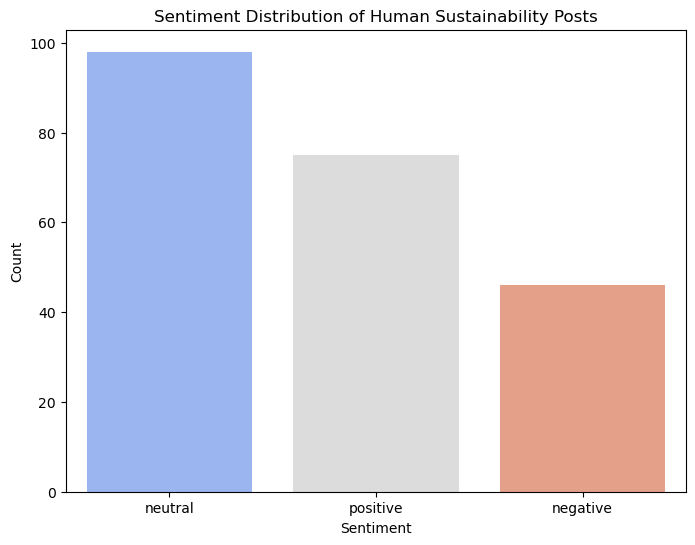

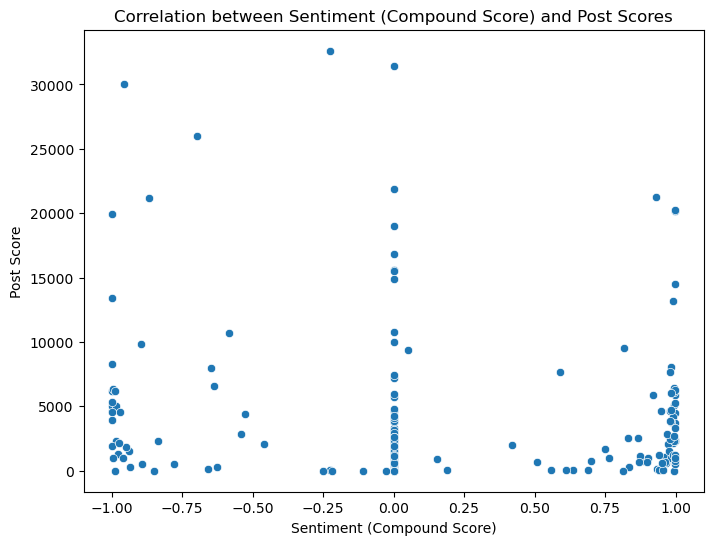

Correlation between sentiment (compound score) and post scores: -0.11
Correlation coefficient: -0.1055
t-statistic: -1.5623
p-value: 0.1197
The correlation is not significant (p ≥ 0.05)


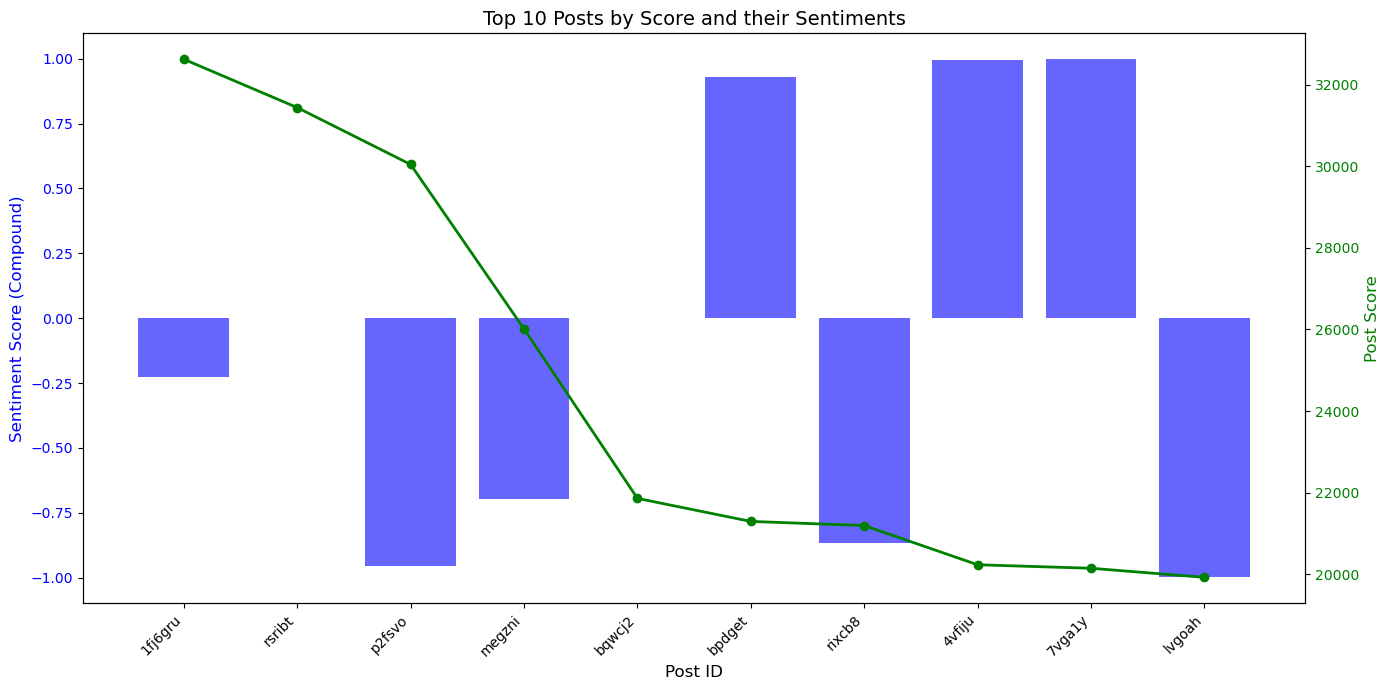

Post Title          Author  Score  \
10                  New hire died coz of work pressure      kausthab87  32622   
2    A team of scientists has developed a 'smart' f...        Wagamaga  31437   
77   Why the FUCK are we still catering to billiona...       audyaudvi  30043   
85   If you still don't believe in - or care about ...      Kayshanski  26012   
3    Amazon's Jeff Bezos is enamored with the idea ...          clayt6  21859   
133  We’re NASA experts working to send humans to t...            nasa  21294   
73   Can americans really get fired at any point fo...        kukkelii  21193   
217     [text] Three Simple Ideas that Changed My Life    Jockobutters  20232   
173  I will tell you exactly what is going on here,...       Suuperdad  20146   
161                               Why Humans Avoid War  SpacePaladin15  19924   

     Comments Count  Post ID  \
10             1120  1fj6gru   
2               591   rsribt   
77             3557   p2fsvo   
85             3732   megzni   
3              2351   bqwcj2   
133            1717   bpdget   
73             3247   rixcb8   
217             900   4vfiju   
173            1419   7vga1y   
161             489   lvgoah   

                                              Post URL        Created Date  \
10              https://www.reddit.com/gallery/1fj6gru 2024-09-17 20:14:44   
2    https://www.ntu.edu.sg/news/detail/bacteria-ki... 2021-12-31 11:58:22   
77   https://www.reddit.com/r/TooAfraidToAsk/commen... 2021-08-11 17:52:03   
85   https://www.reddit.com/r/TrueOffMyChest/commen... 2021-03-27 17:19:44   
3    http://www.astronomy.com/news/2019/05/oneill-c... 2019-05-20 16:38:27   
133  https://www.reddit.com/r/space/comments/bpdget... 2019-05-16 16:47:20   
73   https://www.reddit.com/r/antiwork/comments/rix... 2021-12-18 03:36:17   
217  https://www.reddit.com/r/GetMotivated/comments... 2016-07-31 05:46:00   
173  https://www.reddit.com/r/CryptoCurrency/commen... 2018-02-05 18:21:09   
161  https://www.reddit.com/r/HFY/comments/lvgoah/w... 2021-03-01 19:36:07   

                                             Post Text  Subscribers  \
10   This story needs to reach as many as possible....       742613   
2                                                  N/A     32955842   
77   Seriously, what? Why? Why are we enabling the ...      1826331   
85   As an immunocompromised individual, throughout...      2316244   
3                                                  N/A     26739378   
133  UPDATE:That’s a wrap! We’re signing off, but w...     26739391   
73   I see this again and again like lately there w...      2846543   
217  I've been wanting to write down these ideas fo...     23144743   
173  /edit: Hi /r/all. While I have your attention,...      8793394   
161  [Available on Amazon as a hard-copy and an eBo...       340876   

          Subreddit  Link Karma  Comment Karma  \
10   recruitinghell       27093           3018   
2           science    11945904         388693   
77   TooAfraidToAsk       25989           6440   
85   TrueOffMyChest        7488           1139   
3             space     1896875         109008   
133           space      233298         161357   
73         antiwork       73728         185529   
217    GetMotivated       24270         266460   
173  CryptoCurrency       66668         358322   
161             HFY      156527         102254   

                                     Cleaned Post Text  \
10   story need reach many possible country matter ...   
2                                                    n   
77   seriously enabling people fucking planet live ...   
85   immunocompromised individual throughout covid ...   
3                                                    n   
133  update wrap signing invite visit information w...   
73   see like lately note sat bos lady chair fired ...   
217  wanting write idea awhile hope someone else mi...   
173  edit hi r attention want take second time brin...   
161  available amazon hard 

In [1096]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df_posts, palette='coolwarm')
plt.title('Sentiment Distribution of Human Sustainability Posts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Compound', y='Score', data=df_posts)
plt.title('Correlation between Sentiment (Compound Score) and Post Scores')
plt.xlabel('Sentiment (Compound Score)')
plt.ylabel('Post Score')
plt.show()
correlation = df_posts['Compound'].corr(df_posts['Score'])
print(f'Correlation between sentiment (compound score) and post scores: {correlation:.2f}')

n = len(df_posts)

t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed test

print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")
    
top_10_posts = df_posts.sort_values(by='Score', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_xlabel('Post ID', fontsize=12)
ax1.set_ylabel('Sentiment Score (Compound)', color='blue', fontsize=12)
ax1.bar(top_10_posts['Post ID'], top_10_posts['Compound'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.set_ylabel('Post Score', color='green', fontsize=12)
ax2.plot(top_10_posts['Post ID'], top_10_posts['Score'], color='green', marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Posts by Score and their Sentiments', fontsize=14)

plt.tight_layout()

plt.show()

top_10_posts

In [1097]:
top_10_posts[top_10_posts['Post ID'] == '1fj6gru']

Post Title      Author  Score  Comments Count  \
10  New hire died coz of work pressure  kausthab87  32622            1120   

    Post ID                                Post URL        Created Date  \
10  1fj6gru  https://www.reddit.com/gallery/1fj6gru 2024-09-17 20:14:44   

                                            Post Text  Subscribers  \
10  This story needs to reach as many as possible....       742613   

         Subreddit  Link Karma  Comment Karma  \
10  recruitinghell       27093           3018   

                                    Cleaned Post Text  \
10  story need reach many possible country matter ...   

                                     Sentiment Scores  Compound Sentiment  \
10  {'neg': 0.106, 'neu': 0.751, 'pos': 0.143, 'co...   -0.2263  negative   

    Log Score  
10  10.392773

Difinitely negative and sensitive

In [1099]:
top_10_posts[top_10_posts['Author'] == 'SpacePaladin15']

Post Title          Author  Score  Comments Count Post ID  \
161  Why Humans Avoid War  SpacePaladin15  19924             489  lvgoah   

                                              Post URL        Created Date  \
161  https://www.reddit.com/r/HFY/comments/lvgoah/w... 2021-03-01 19:36:07   

                                             Post Text  Subscribers Subreddit  \
161  [Available on Amazon as a hard-copy and an eBo...       340876       HFY   

     Link Karma  Comment Karma  \
161      156527         102254   

                                     Cleaned Post Text  \
161  available amazon hard copy ebook next human su...   

                                      Sentiment Scores  Compound Sentiment  \
161  {'neg': 0.263, 'neu': 0.588, 'pos': 0.149, 'co...   -0.9989  negative   

     Log Score  
161   9.899731

This is not relate, so remodin and reanalyzing needed:

In [1105]:
df_posts = df_posts.drop(index=161)

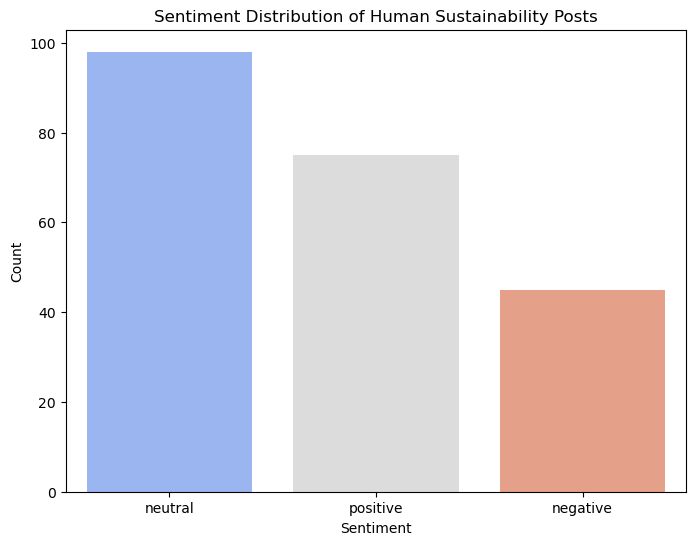

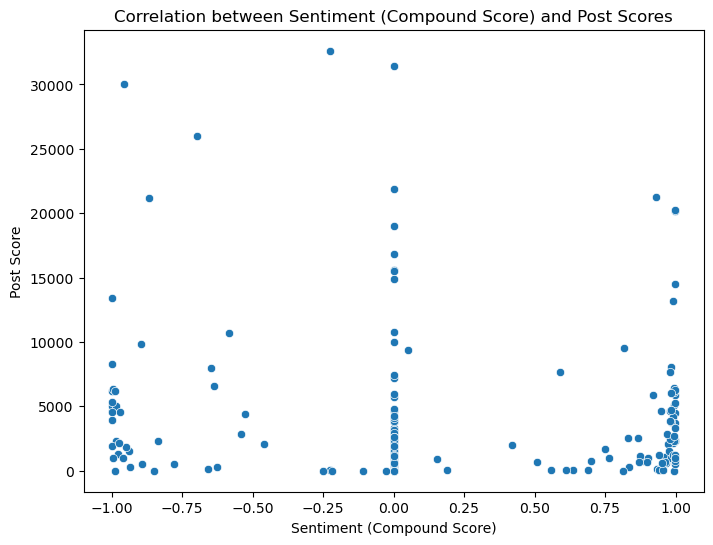

Correlation between sentiment (compound score) and post scores: -0.08
Correlation coefficient: -0.0848
t-statistic: -1.2509
p-value: 0.2123
The correlation is not significant (p ≥ 0.05)


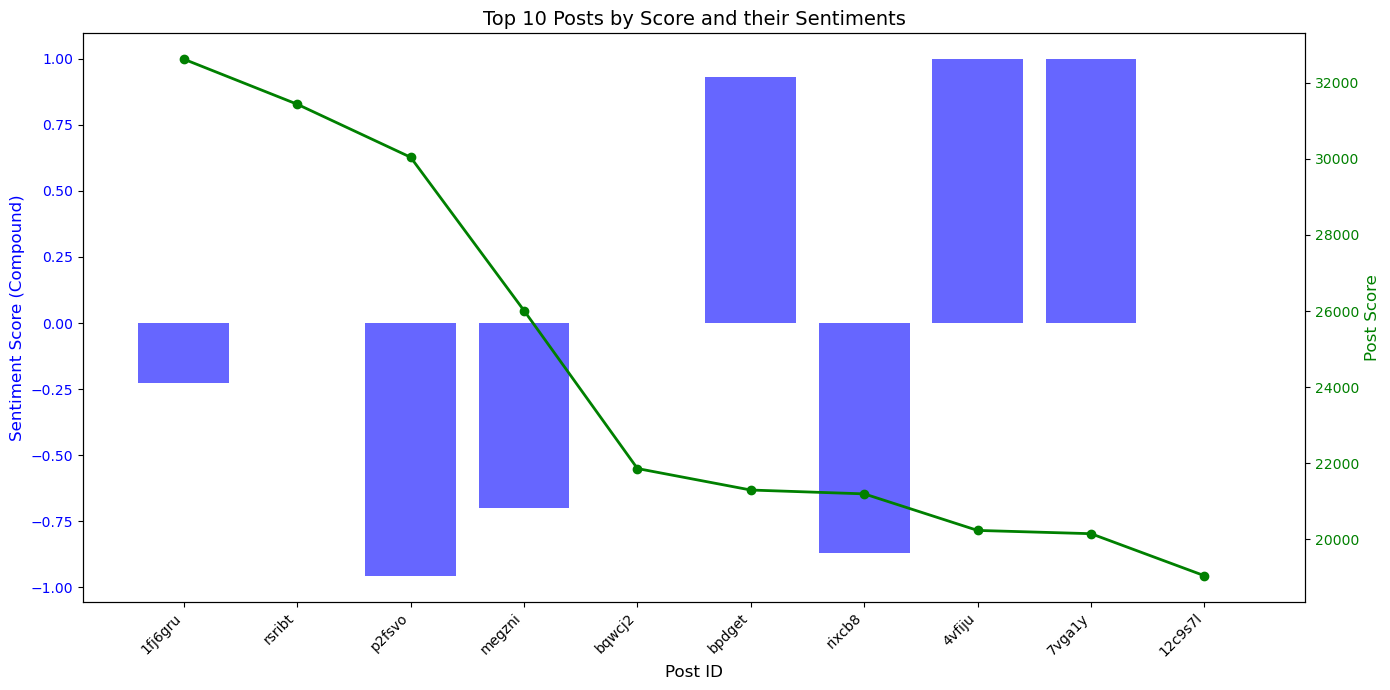

Post Title               Author  \
10                  New hire died coz of work pressure           kausthab87   
2    A team of scientists has developed a 'smart' f...             Wagamaga   
77   Why the FUCK are we still catering to billiona...            audyaudvi   
85   If you still don't believe in - or care about ...           Kayshanski   
3    Amazon's Jeff Bezos is enamored with the idea ...               clayt6   
133  We’re NASA experts working to send humans to t...                 nasa   
73   Can americans really get fired at any point fo...             kukkelii   
217     [text] Three Simple Ideas that Changed My Life         Jockobutters   
173  I will tell you exactly what is going on here,...            Suuperdad   
71   Ocean Cleanup removes 200,000th kilogram of pl...  NinjaElectricMeteor   

     Score  Comments Count  Post ID  \
10   32622            1120  1fj6gru   
2    31437             591   rsribt   
77   30043            3557   p2fsvo   
85   26012            3732   megzni   
3    21859            2351   bqwcj2   
133  21294            1717   bpdget   
73   21193            3247   rixcb8   
217  20232             900   4vfiju   
173  20146            1419   7vga1y   
71   19041             492  12c9s7l   

                                              Post URL        Created Date  \
10              https://www.reddit.com/gallery/1fj6gru 2024-09-17 20:14:44   
2    https://www.ntu.edu.sg/news/detail/bacteria-ki... 2021-12-31 11:58:22   
77   https://www.reddit.com/r/TooAfraidToAsk/commen... 2021-08-11 17:52:03   
85   https://www.reddit.com/r/TrueOffMyChest/commen... 2021-03-27 17:19:44   
3    http://www.astronomy.com/news/2019/05/oneill-c... 2019-05-20 16:38:27   
133  https://www.reddit.com/r/space/comments/bpdget... 2019-05-16 16:47:20   
73   https://www.reddit.com/r/antiwork/comments/rix... 2021-12-18 03:36:17   
217  https://www.reddit.com/r/GetMotivated/comments... 2016-07-31 05:46:00   
173  https://www.reddit.com/r/CryptoCurrency/commen... 2018-02-05 18:21:09   
71   https://nltimes.nl/2023/04/05/video-ocean-clea... 2023-04-05 07:35:22   

                                             Post Text  Subscribers  \
10   This story needs to reach as many as possible....       742613   
2                                                  N/A     32955842   
77   Seriously, what? Why? Why are we enabling the ...      1826331   
85   As an immunocompromised individual, throughout...      2316244   
3                                                  N/A     26739378   
133  UPDATE:That’s a wrap! We’re signing off, but w...     26739391   
73   I see this again and again like lately there w...      2846543   
217  I've been wanting to write down these ideas fo...     23144743   
173  /edit: Hi /r/all. While I have your attention,...      8793394   
71                                                 N/A     20046263   

          Subreddit  Link Karma  Comment Karma  \
10   recruitinghell       27093           3018   
2           science    11945904         388693   
77   TooAfraidToAsk       25989           6440   
85   TrueOffMyChest        7488           1139   
3             space     1896875         109008   
133           space      233298         161357   
73         antiwork       73728         185529   
217    GetMotivated       24270         266460   
173  CryptoCurrency       66668         358322   
71    UpliftingNews      196378         156546   

                                     Cleaned Post Text  \
10   story need reach many possible country matter ...   
2                                                    n   
77   seriously enabling people fucking planet live ...   
85   immunocompromised individual throughout covid ...   
3                                                    n   
133  update wrap signing invite visit information w...   
73   see like lately note sat bos lady chair fired ...   
217  wanting write idea awhile hope someone else mi...   
173  edit hi r attention want 

In [1106]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df_posts, palette='coolwarm')
plt.title('Sentiment Distribution of Human Sustainability Posts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Compound', y='Score', data=df_posts)
plt.title('Correlation between Sentiment (Compound Score) and Post Scores')
plt.xlabel('Sentiment (Compound Score)')
plt.ylabel('Post Score')
plt.show()
correlation = df_posts['Compound'].corr(df_posts['Score'])
print(f'Correlation between sentiment (compound score) and post scores: {correlation:.2f}')

n = len(df_posts)

t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed test

print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")
    
top_10_posts = df_posts.sort_values(by='Score', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_xlabel('Post ID', fontsize=12)
ax1.set_ylabel('Sentiment Score (Compound)', color='blue', fontsize=12)
ax1.bar(top_10_posts['Post ID'], top_10_posts['Compound'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.set_ylabel('Post Score', color='green', fontsize=12)
ax2.plot(top_10_posts['Post ID'], top_10_posts['Score'], color='green', marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Posts by Score and their Sentiments', fontsize=14)

plt.tight_layout()

plt.show()

top_10_posts

In [1107]:
top_10_posts[top_10_posts['Post ID'] == 'p2fsvo']

Post Title     Author  Score  \
77  Why the FUCK are we still catering to billiona...  audyaudvi  30043   

    Comments Count Post ID                                           Post URL  \
77            3557  p2fsvo  https://www.reddit.com/r/TooAfraidToAsk/commen...   

          Created Date                                          Post Text  \
77 2021-08-11 17:52:03  Seriously, what? Why? Why are we enabling the ...   

    Subscribers       Subreddit  Link Karma  Comment Karma  \
77      1826331  TooAfraidToAsk       25989           6440   

                                    Cleaned Post Text  \
77  seriously enabling people fucking planet live ...   

                                     Sentiment Scores  Compound Sentiment  \
77  {'neg': 0.244, 'neu': 0.548, 'pos': 0.209, 'co...   -0.9556  negative   

    Log Score  
77  10.310418

Correlation between Link Karma and Post Scores:

In [1109]:
author_avg_score = df_posts.groupby('Author')['Score'].mean().reset_index()
author_avg_score.columns = ['Author', 'Avg_Score']

author_karma_data = df_posts[['Author', 'Link Karma', 'Comment Karma']].drop_duplicates()

author_stats = pd.merge(author_avg_score, author_karma_data, on='Author', how='inner')

correlation_matrix = author_stats[['Avg_Score', 'Link Karma', 'Comment Karma']].corr()

print(correlation_matrix)

               Avg_Score  Link Karma  Comment Karma
Avg_Score       1.000000    0.036807       0.150236
Link Karma      0.036807    1.000000       0.483643
Comment Karma   0.150236    0.483643       1.000000


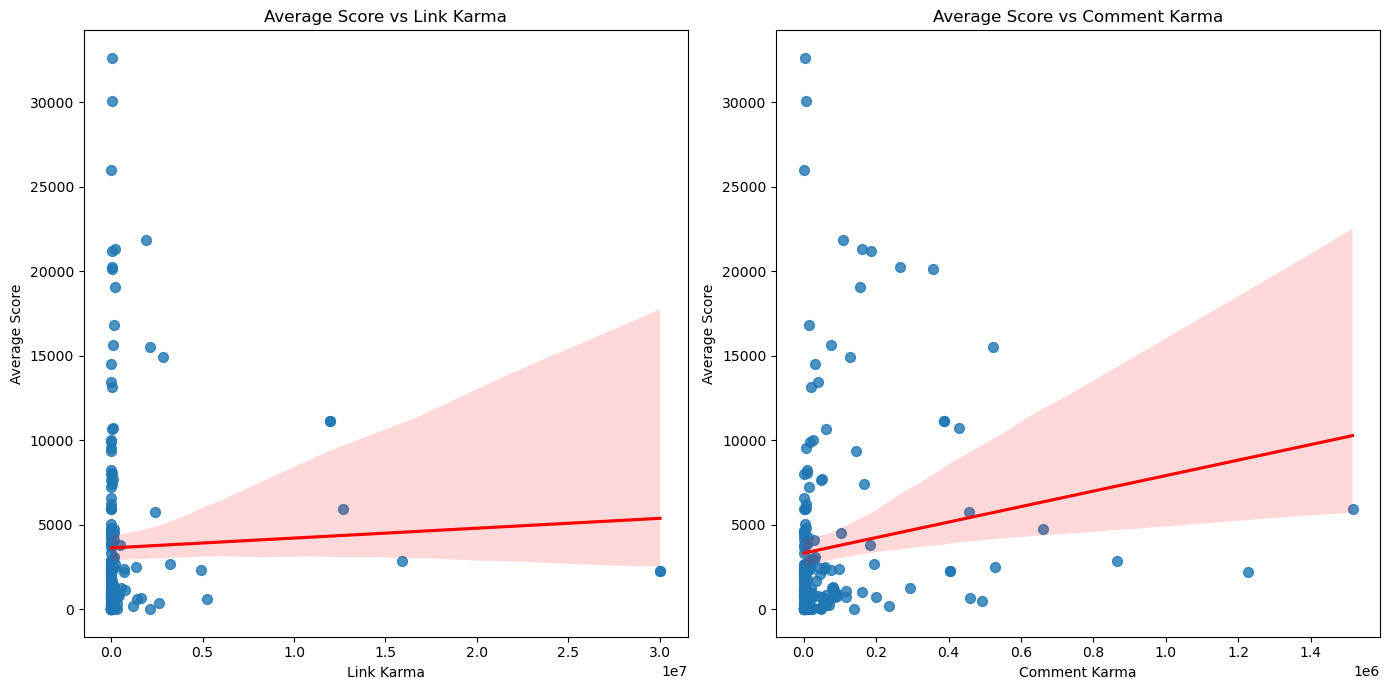

In [1110]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.regplot(x='Link Karma', y='Avg_Score', data=author_stats, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Average Score vs Link Karma')
plt.xlabel('Link Karma')
plt.ylabel('Average Score')

plt.subplot(1, 2, 2)
sns.regplot(x='Comment Karma', y='Avg_Score', data=author_stats, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Average Score vs Comment Karma')
plt.xlabel('Comment Karma')
plt.ylabel('Average Score')

plt.tight_layout()
plt.show()

In [1111]:
link_karma_corr = author_stats['Avg_Score'].corr(author_stats['Link Karma'])

n = len(author_stats)  

t_stat = link_karma_corr * np.sqrt((n - 2) / (1 - link_karma_corr**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2

print(f"Correlation coefficient: {link_karma_corr:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05  
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: 0.0368
t-statistic: 0.5104
p-value: 0.6104
The correlation is not significant (p ≥ 0.05)


In [1112]:
comment_karma_corr = author_stats['Avg_Score'].corr(author_stats['Comment Karma'])

t_stat_comment = comment_karma_corr * np.sqrt((n - 2) / (1 - comment_karma_corr**2))
p_value_comment = stats.t.sf(np.abs(t_stat_comment), df=n-2) * 2  

print(f"Comment Karma Correlation: {comment_karma_corr:.4f}")
print(f"Comment Karma t-statistic: {t_stat_comment:.4f}")
print(f"Comment Karma p-value: {p_value_comment:.4f}")

if p_value_comment < alpha:
    print(f"The correlation with Comment Karma is significant (p < {alpha})")
else:
    print(f"The correlation with Comment Karma is not significant (p ≥ {alpha})")

Comment Karma Correlation: 0.1502
Comment Karma t-statistic: 2.1056
Comment Karma p-value: 0.0365
The correlation with Comment Karma is significant (p < 0.05)


In [1113]:
spearman_corr, spearman_p = spearmanr(author_stats['Comment Karma'], author_stats['Avg_Score'])
print(f"Spearman's Rank Correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

# Kendall's Tau Correlation
kendall_corr, kendall_p = kendalltau(author_stats['Comment Karma'], author_stats['Avg_Score'])
print(f"Kendall's Tau Correlation: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")

Spearman's Rank Correlation: 0.2787, p-value: 0.0001
Kendall's Tau Correlation: 0.1893, p-value: 0.0001


suggest statistically significant positive relationships between the variables being analyzed

(0.2553): This value suggests a weak positive monotonic relationship

Since the p-value is well below the common significance level of 0.05, the result is statistically significant.

(0.1722): This also indicates a weak positive relationship but is generally lower than Spearman's coefficient, which is expected because Kendall's Tau tends to produce smaller values when measuring the same relationship.

Similar to Spearman's, this p-value is below the 0.05 threshold, indicating that the relationship is statistically significant.

The significance of the p-values indicates that the correlations are not due to random chance.

Unlike environmental, there is no significance for link karma but similar to it, therte is for comment karma.

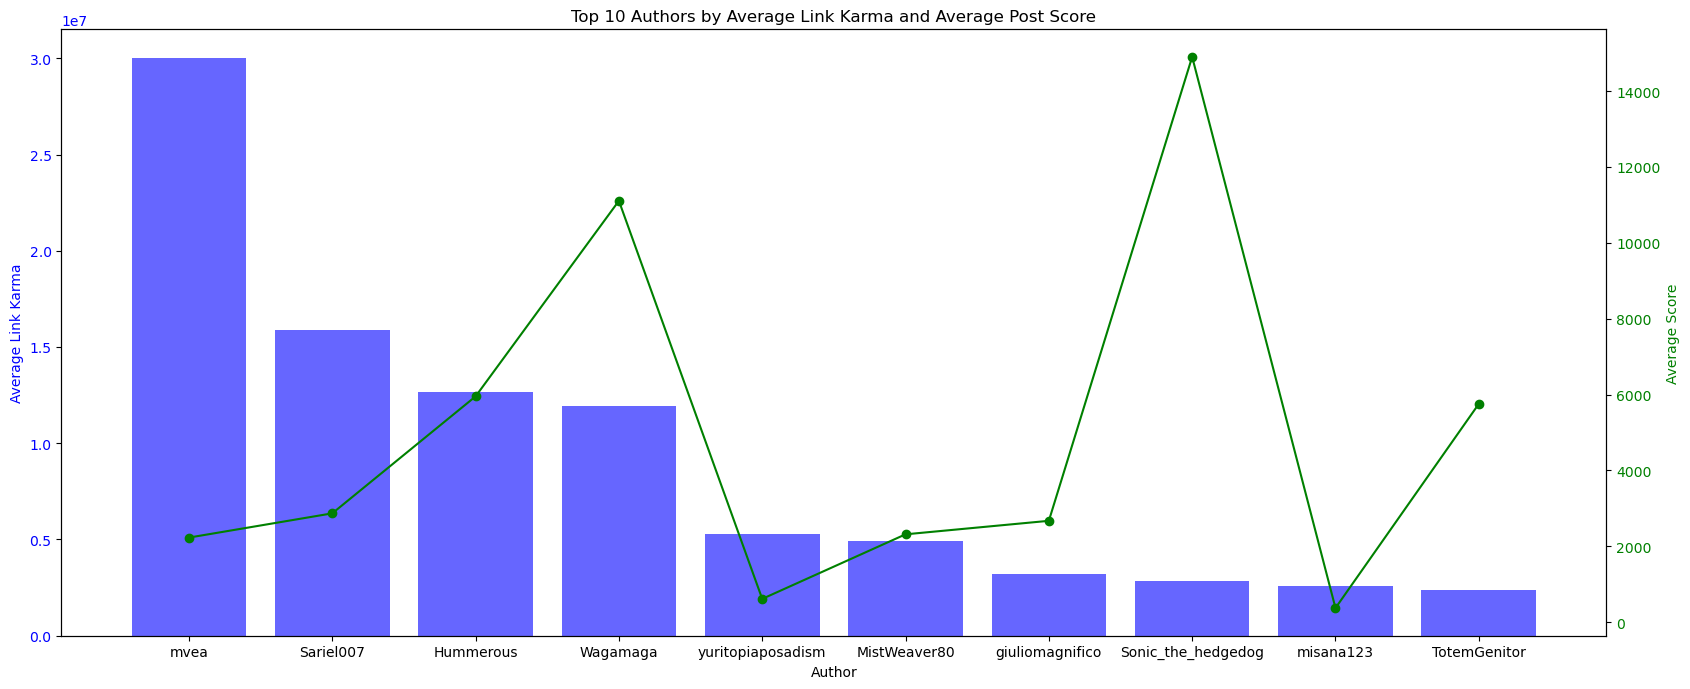

In [1116]:
author_stats = df_posts.groupby('Author').agg(
    avg_link_karma=('Link Karma', 'mean'),  # Average link karma by each author
    avg_score=('Score', 'mean')             # Average score of posts by the author
).reset_index()

top_10_authors = author_stats.sort_values(by='avg_link_karma', ascending=False).head(10)

# Step 3: Create a figure and axis for the dual-axis plot
fig, ax1 = plt.subplots(figsize=(17,7))

# Plot the average link karma as bars on the first y-axis
ax1.set_xlabel('Author')
ax1.set_ylabel('Average Link Karma', color='blue')
ax1.bar(top_10_authors['Author'], top_10_authors['avg_link_karma'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

# Step 4: Create a second y-axis for the average post score
ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_authors['Author'], top_10_authors['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

# Step 5: Add a title and show the plot
plt.title('Top 10 Authors by Average Link Karma and Average Post Score')
plt.xticks(rotation=180)
plt.tight_layout()
plt.show()

mvea is present evrywhere!

In [1118]:
mv_posts = df_posts[df_posts['Author'].str.lower() == 'mvea']

mv_posts

Post Title Author  Score  \
35  Not having children a way to cut a person's ca...   mvea   1305   
49  Placing human decision-making, known as the "o...   mvea   3153   

    Comments Count Post ID                                           Post URL  \
35             227  bbldzx  https://www.cbc.ca/news/canada/british-columbi...   
49             100  6qhgoy  https://www.nature.com/articles/s41598-017-066...   

          Created Date Post Text  Subscribers          Subreddit  Link Karma  \
35 2019-04-10 14:24:48       N/A       554937  EverythingScience    30008821   
49 2017-07-30 15:56:19       N/A     32955841            science    30008821   

    Comment Karma Cleaned Post Text  \
35         403089                 n   
49         403091                 n   

                                     Sentiment Scores  Compound Sentiment  \
35  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...       0.0   neutral   
49  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...       0.0   neutral   

    Log Score  
35   7.174724  
49   8.056427

In [1119]:
for index, title in enumerate(mv_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Post 1:
Not having children a way to cut a person's carbon footprint, some environmental groups say - Voluntary Human Extinction Movement, Population Matters say having fewer kids key to sustaining our existence
----------------------------------------
Post 2:
Placing human decision-making, known as the "optometrist's algorithm", at the center of computer optimization, yielded sustained hot plasmas in a colliding beam fusion reactor.
----------------------------------------


Very scientific

In [1121]:
sonic_posts = df_posts[df_posts['Author'].str.lower() == 'sonic_the_hedgedog']

sonic_posts

Post Title              Author  Score  Comments Count  \
192  We're Moving to Antarctica  Sonic_the_hedgedog  14901              98   

     Post ID                             Post URL        Created Date  \
192  16wba6r  https://i.redd.it/z4dae6ot6frb1.jpg 2023-09-30 18:31:41   

    Post Text  Subscribers Subreddit  Link Karma  Comment Karma  \
192       N/A      1450596    tumblr     2852418         127642   

    Cleaned Post Text                                   Sentiment Scores  \
192                 n  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...   

     Compound Sentiment  Log Score  
192       0.0   neutral   9.609251

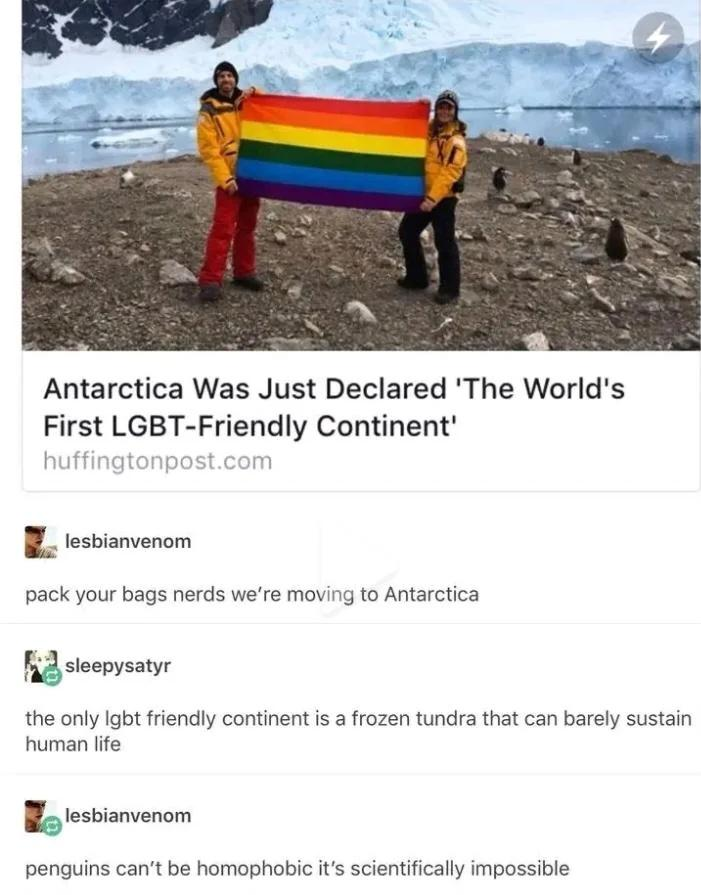

Sarcastic and funny

Correlation between Number of Posts by Authors and Post Scores:

In [1125]:
author_post_count = df_posts.groupby('Author').size().reset_index(name='Num_Posts')

author_avg_score = df_posts.groupby('Author')['Score'].mean().reset_index(name='Avg_Score')

author_stats = pd.merge(author_post_count, author_avg_score, on='Author')

n = len(author_stats)

pearson_corr, pearson_p_value = stats.pearsonr(author_stats['Num_Posts'], author_stats['Avg_Score'])

t_stat_pearson = pearson_corr * np.sqrt((n - 2) / (1 - pearson_corr**2))
p_value_ttest_pearson = stats.t.sf(np.abs(t_stat_pearson), df=n-2) * 2  # two-tailed test

print(f"Pearson's Correlation: {pearson_corr:.4f}, p-value: {pearson_p_value:.4f}")
print(f"Pearson's Correlation t-statistic: {t_stat_pearson:.4f}, p-value: {p_value_ttest_pearson:.4f}")

alpha = 0.05  # significance level
if p_value_ttest_pearson < alpha:
    print(f"The Pearson correlation is significant (p < {alpha})")
else:
    print(f"The Pearson correlation is not significant (p ≥ {alpha})")

Pearson's Correlation: 0.0139, p-value: 0.8483
Pearson's Correlation t-statistic: 0.1916, p-value: 0.8483
The Pearson correlation is not significant (p ≥ 0.05)


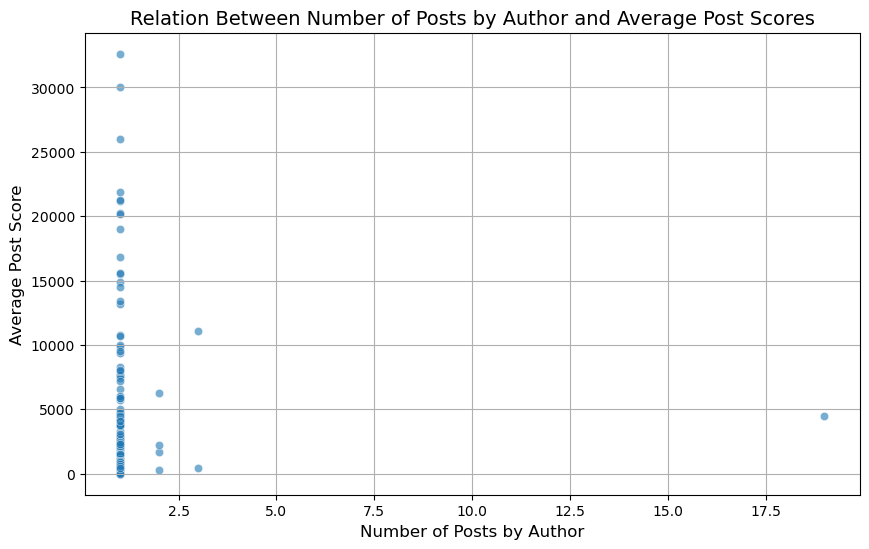

In [1126]:
author_post_counts = df_posts.groupby('Author').size().reset_index(name='Num Posts')

author_avg_scores = df_posts.groupby('Author')['Score'].mean().reset_index(name='Avg_Score')

author_stats = pd.merge(author_post_counts, author_avg_scores, on='Author')

plt.figure(figsize=(10, 6))

sns.scatterplot(x='Num Posts', y='Avg_Score', data=author_stats, alpha=0.6)
plt.title('Relation Between Number of Posts by Author and Average Post Scores', fontsize=14)
plt.xlabel('Number of Posts by Author', fontsize=12)
plt.ylabel('Average Post Score', fontsize=12)
plt.grid(True)

plt.show()

Same as environmental

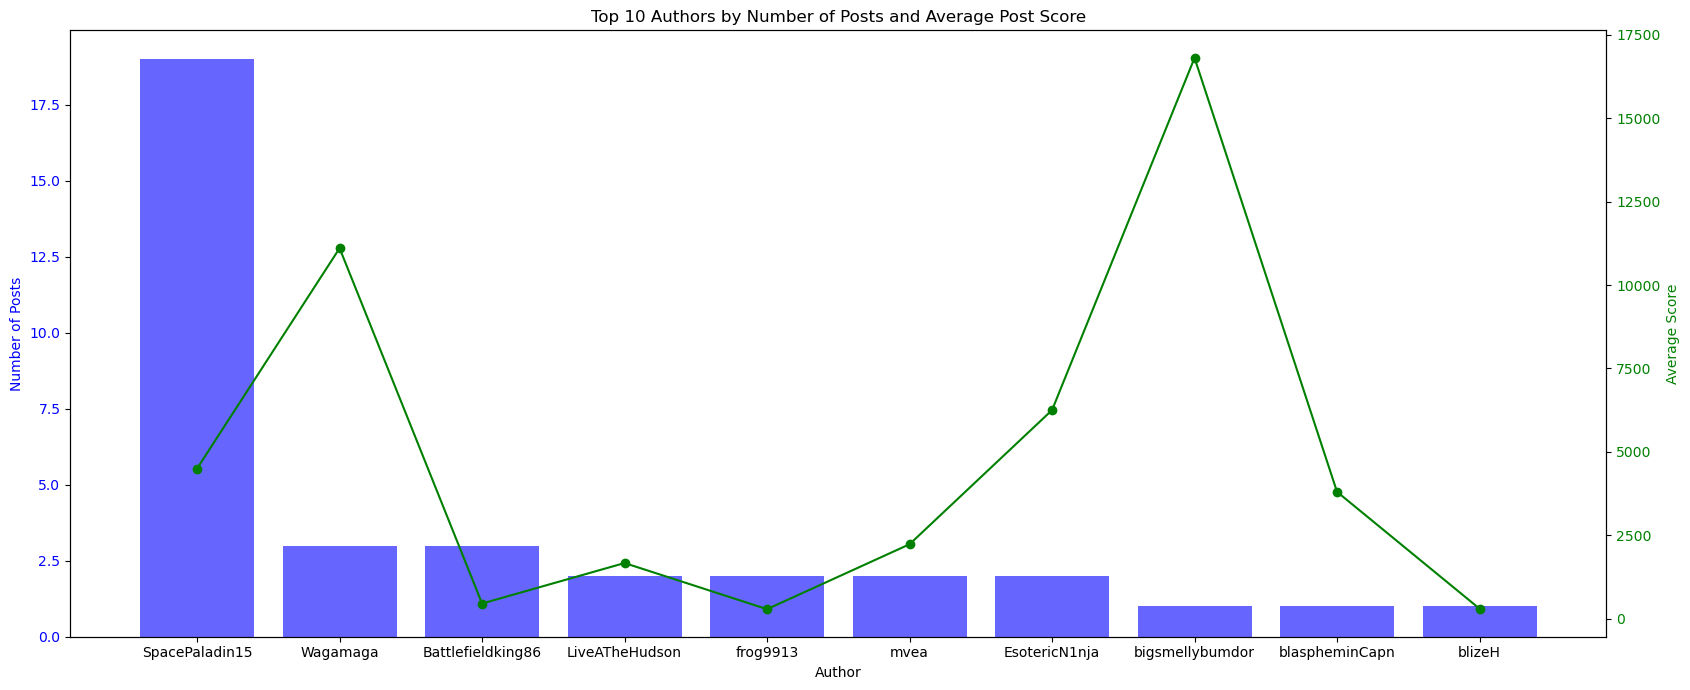

In [1128]:
author_stats = df_posts.groupby('Author').agg(
    num_posts=('Post ID', 'count'),  # Number of posts by each author
    avg_score=('Score', 'mean')      # Average score of posts by the author
).reset_index()

top_10_authors = author_stats.sort_values(by='num_posts', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(17,7))

ax1.set_xlabel('Author')
ax1.set_ylabel('Number of Posts', color='blue')
ax1.bar(top_10_authors['Author'], top_10_authors['num_posts'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_authors['Author'], top_10_authors['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Authors by Number of Posts and Average Post Score')
plt.xticks(rotation=180)
plt.tight_layout()
plt.show()

In [1129]:
sp_posts = df_posts[df_posts['Author'].str.lower() == 'spacepaladin15']

sp_posts

Post Title          Author  Score  Comments Count  \
98     The Nature of Predators 48  SpacePaladin15   6227             953   
100    The Nature of Predators 56  SpacePaladin15   6163             809   
105    The Nature of Predators 52  SpacePaladin15   6330             647   
112    The Nature of Predators 49  SpacePaladin15   6156             629   
114   The Nature of Predators 116  SpacePaladin15   3914             496   
123    The Nature of Predators 82  SpacePaladin15   5121             473   
126    The Nature of Predators 54  SpacePaladin15   6279             475   
134    The Nature of Predators 90  SpacePaladin15   4644             400   
136    The Nature of Predators 94  SpacePaladin15   4620             387   
138    The Nature of Predators 78  SpacePaladin15   4995             402   
142    The Nature of Predators 74  SpacePaladin15   5292             385   
154    The Nature of Predators 72  SpacePaladin15   5310             361   
156    The Nature of Predators 91  SpacePaladin15   4539             353   
160   The Nature of Predators 175  SpacePaladin15   1954             349   
163    The Nature of Predators 92  SpacePaladin15   4543             331   
174   The Nature of Predators 130  SpacePaladin15   3323             281   
193   The Nature of Predators 154  SpacePaladin15   2452             260   
226  The Nature of Predators 2-35  SpacePaladin15    975             261   
234   The Nature of Predators 148  SpacePaladin15   2669             193   

     Post ID                                           Post URL  \
98    xlyo9q  https://www.reddit.com/r/HFY/comments/xlyo9q/t...   
100   y83oj1  https://www.reddit.com/r/HFY/comments/y83oj1/t...   
105   xx6l1l  https://www.reddit.com/r/HFY/comments/xx6l1l/t...   
112   xokdnb  https://www.reddit.com/r/HFY/comments/xokdnb/t...   
114  13k2zef  https://www.reddit.com/r/HFY/comments/13k2zef/...   
123  10f9m6h  https://www.reddit.com/r/HFY/comments/10f9m6h/...   
126   y2zy9q  https://www.reddit.com/r/HFY/comments/y2zy9q/t...   
134  11304kl  https://www.reddit.com/r/HFY/comments/11304kl/...   
136  11f67tj  https://www.reddit.com/r/HFY/comments/11f67tj/...   
138  1035tya  https://www.reddit.com/r/HFY/comments/1035tya/...   
142   zrpl0s  https://www.reddit.com/r/HFY/comments/zrpl0s/t...   
154   zltkjc  https://www.reddit.com/r/HFY/comments/zltkjc/t...   
156  115h9e6  https://www.reddit.com/r/HFY/comments/115h9e6/...   
160  18ef5kx  https://www.reddit.com/r/HFY/comments/18ef5kx/...   
163  1193opz  https://www.reddit.com/r/HFY/comments/1193opz/...   
174  14rbvh0  https://www.reddit.com/r/HFY/comments/14rbvh0/...   
193  16tlknc  https://www.reddit.com/r/HFY/comments/16tlknc/...   
226  1cphz27  https://www.reddit.com/r/HFY/comments/1cphz27/...   
234  16bp0h7  https://www.reddit.com/r/HFY/comments/16bp0h7/...   

           Created Date                                          Post Text  \
98  2022-09-23 16:11:00  [First](https://www.reddit.com/r/HFY/comments/...   
100 2022-10-19 16:07:11  [First](https://www.reddit.com/r/HFY/comments/...   
105 2022-10-06 16:25:57  [First](https://www.reddit.com/r/HFY/comments/...   
112 2022-09-26 16:10:13  [First](https://www.reddit.com/r/HFY/comments/...   
114 2023-05-17 16:14:20  [First](https://www.reddit.com/r/HFY/comments/...   
123 2023-01-18 16:08:27  [First](https://www.reddit.com/r/HFY/comments/...   
126 2022-10-13 16:19:26  [First](https://www.reddit.com/r/HFY/comments/...   
134 2023-02-15 16:07:02  [First](https://www.reddit.com/r/HFY/comments/...   
136 2023-03-01 16:12:08  [First](https://www.reddit.com/r/HFY/comments/...   
138 2023-01-04 16:06:52  [First](https://www.reddit.com/r/HFY/comments/...   
142 2022-12-21 16:04:54  [First](https://www.reddit.com/r/HFY/comments/...   
154 2022-12-14 16:14:58  [First](https://www.reddit.com/r/HFY/comments/...   
156 2023-02-18 16:04:11  [First](https://www.reddit.com/r/HFY/comments/...   
160 2023-12-09 15:50:56  [First](https://www.reddit.com/r/HFY/comment

Story series, not related, let's reove it and do the analysis.

In [1131]:
sp_posts.index

Index([ 98, 100, 105, 112, 114, 123, 126, 134, 136, 138, 142, 154, 156, 160,
       163, 174, 193, 226, 234],
      dtype='int64')

In [1133]:
df_posts = df_posts.drop([ 98, 100, 105, 112, 114, 123, 126, 134, 136, 138, 142, 154, 156, 160,
       163, 174, 193, 226, 234])

Pearson's Correlation: 0.0166, p-value: 0.8193
Pearson's Correlation t-statistic: 0.2287, p-value: 0.8193
The Pearson correlation is not significant (p ≥ 0.05)


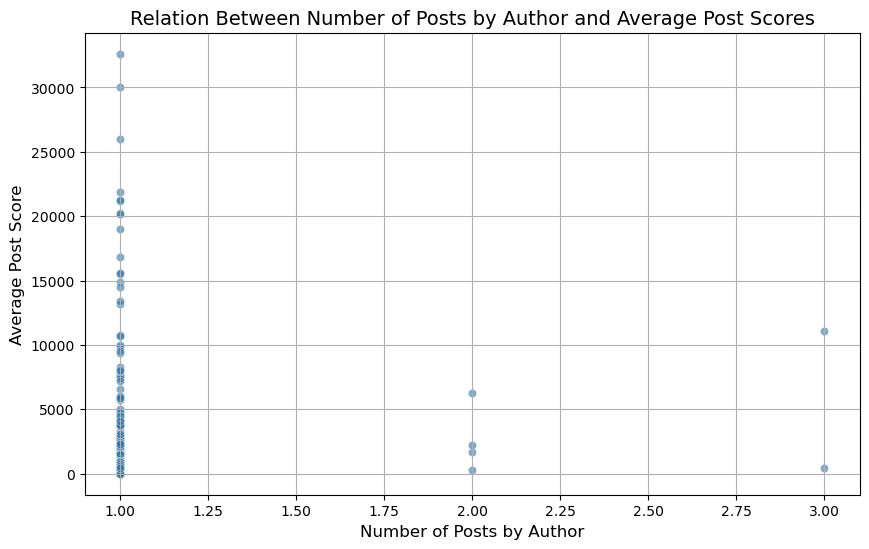

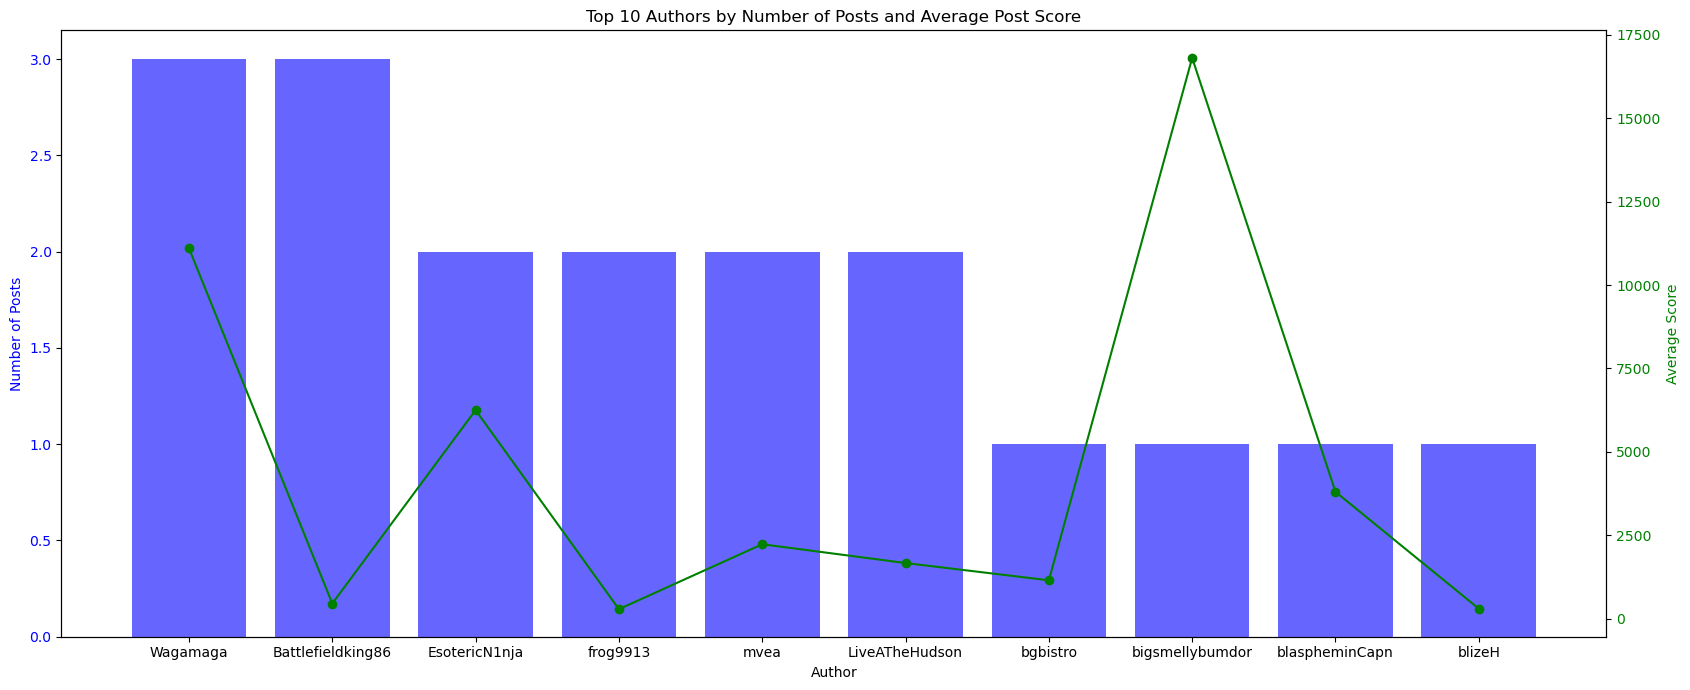

In [1134]:
author_post_count = df_posts.groupby('Author').size().reset_index(name='Num_Posts')

author_avg_score = df_posts.groupby('Author')['Score'].mean().reset_index(name='Avg_Score')

author_stats = pd.merge(author_post_count, author_avg_score, on='Author')

n = len(author_stats)

pearson_corr, pearson_p_value = stats.pearsonr(author_stats['Num_Posts'], author_stats['Avg_Score'])

t_stat_pearson = pearson_corr * np.sqrt((n - 2) / (1 - pearson_corr**2))
p_value_ttest_pearson = stats.t.sf(np.abs(t_stat_pearson), df=n-2) * 2  # two-tailed test

print(f"Pearson's Correlation: {pearson_corr:.4f}, p-value: {pearson_p_value:.4f}")
print(f"Pearson's Correlation t-statistic: {t_stat_pearson:.4f}, p-value: {p_value_ttest_pearson:.4f}")

alpha = 0.05  # significance level
if p_value_ttest_pearson < alpha:
    print(f"The Pearson correlation is significant (p < {alpha})")
else:
    print(f"The Pearson correlation is not significant (p ≥ {alpha})")
    
author_post_counts = df_posts.groupby('Author').size().reset_index(name='Num Posts')

author_avg_scores = df_posts.groupby('Author')['Score'].mean().reset_index(name='Avg_Score')

author_stats = pd.merge(author_post_counts, author_avg_scores, on='Author')

plt.figure(figsize=(10, 6))

sns.scatterplot(x='Num Posts', y='Avg_Score', data=author_stats, alpha=0.6)
plt.title('Relation Between Number of Posts by Author and Average Post Scores', fontsize=14)
plt.xlabel('Number of Posts by Author', fontsize=12)
plt.ylabel('Average Post Score', fontsize=12)
plt.grid(True)

plt.show()

author_stats = df_posts.groupby('Author').agg(
    num_posts=('Post ID', 'count'),  # Number of posts by each author
    avg_score=('Score', 'mean')      # Average score of posts by the author
).reset_index()

top_10_authors = author_stats.sort_values(by='num_posts', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(17,7))

ax1.set_xlabel('Author')
ax1.set_ylabel('Number of Posts', color='blue')
ax1.bar(top_10_authors['Author'], top_10_authors['num_posts'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_authors['Author'], top_10_authors['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Authors by Number of Posts and Average Post Score')
plt.xticks(rotation=180)
plt.tight_layout()
plt.show()

In [1135]:
clay_posts = df_posts[df_posts['Author'].str.lower() == 'clayt6']

clay_posts

Post Title  Author  Score  \
3  Amazon's Jeff Bezos is enamored with the idea ...  clayt6  21859   

   Comments Count Post ID                                           Post URL  \
3            2351  bqwcj2  http://www.astronomy.com/news/2019/05/oneill-c...   

         Created Date Post Text  Subscribers Subreddit  Link Karma  \
3 2019-05-20 16:38:27       N/A     26739378     space     1896875   

   Comment Karma Cleaned Post Text  \
3         109008                 n   

                                    Sentiment Scores  Compound Sentiment  \
3  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...       0.0   neutral   

   Log Score  
3   9.992414

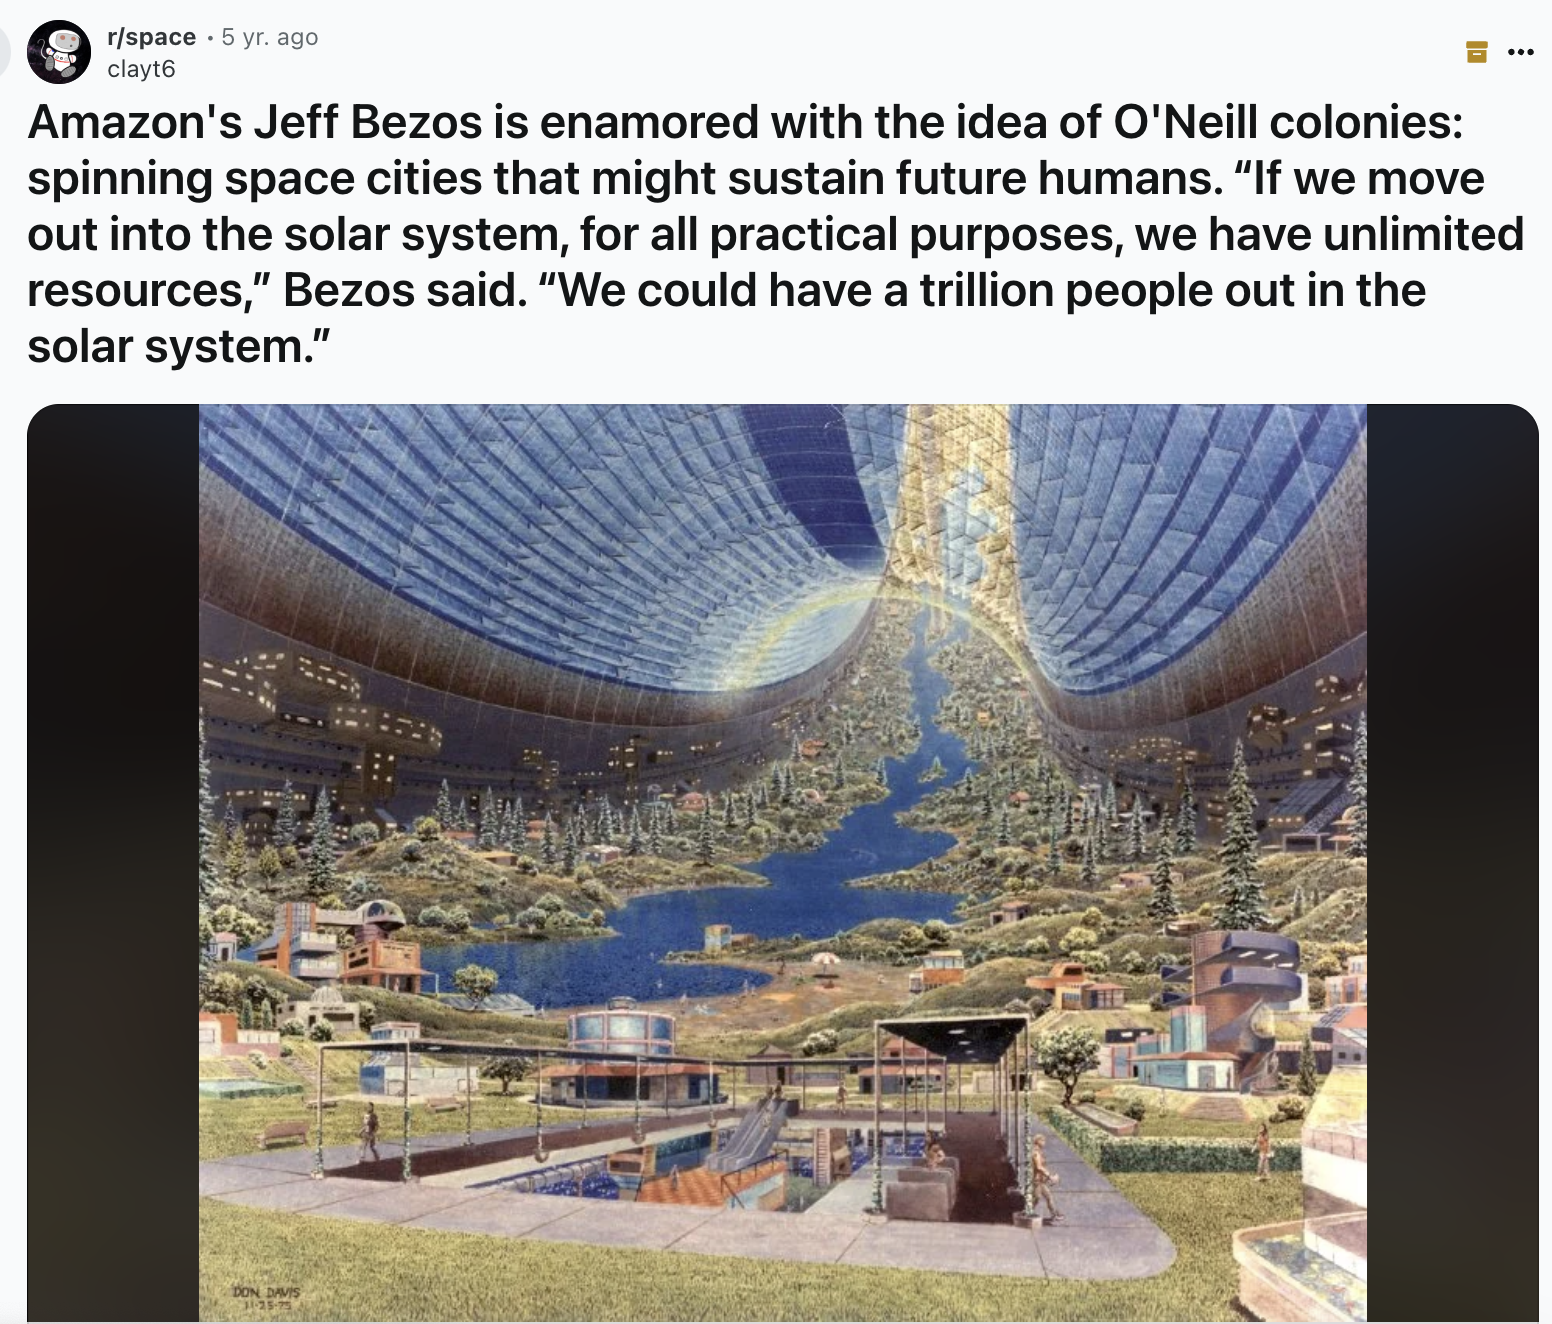

Again living on space is attractive

In [1138]:
df_posts.to_csv('HuSu.csv', index=False)